# Importing

In [57]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi


# Datasets Preparation

In [58]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')
    ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_biol_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Biological variables
    sil = ds_bio.silicon
    flag = ds_bio.flagellates
    diat = ds_bio.diatoms

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask, sil, flag, diat)


# Masking

In [59]:
def masking (depth, temp, saline, mask, sil, flag, diat):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    sil = sil.where(mask[0,depth]==1)
    flag = flag.where(mask[0,depth]==1)
    diat = diat.where(mask[0,depth]==1)

    return (temp, saline, sil, flag, diat)

# SOM

In [60]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
    inputs2 = np.transpose(inputs)  
    inputs2 = inputs2[indx[:,0]]

    # SOM
    temp_som = SOM(m=2, n=3, dim= inputs2[0,:].size)
    temp_som.fit(inputs2)
    predictions = temp_som.predict(inputs2)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2, predictions, clusters)


# Printing

In [61]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [62]:
def plotting (depth, clusters, unique, sil, flag, diat):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': temp[0,depth].y, 'x': temp[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    fig, ax = plt.subplots(2,2, figsize=(15, 20))

    cmap = plt.get_cmap('viridis', unique.max()+1)
    cmap.set_bad('gray')


    map.plot.pcolormesh(ax=ax[0,0], cmap=cmap, levels= np.concatenate((unique,[unique.size])), cbar_kwargs={'ticks': unique})
    
    cmap = plt.get_cmap('Accent')
    cmap.set_bad('gray')
    sil[0,depth].plot.pcolormesh(ax=ax[0,1], cmap=cmap) 
    flag[0,depth].plot.pcolormesh(ax=ax[1,0], cmap=cmap) 
    diat[0,depth].plot.pcolormesh(ax=ax[1,1], cmap=cmap) 

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])
    sa_vi.set_aspect(ax[1,1])

    ax[0,0].title.set_text('Clustering')
    ax[0,1].title.set_text('Silicones')
    ax[1,0].title.set_text('Flaggelates')
    ax[1,1].title.set_text('Diatoms')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters ,' + str(date[0].year) + '/' + month + '/' + day)
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 9972 

The minimum temperature for cluster 0 is 7.14 degrees Celsius
The maximum temperature for cluster 0 is 9.83 degrees Celsius
The mean temperature for cluster 0 is 8.5 degrees Celsius 

The minimum salinity for cluster 0 is 28.03 g/kg
The maximum salinity for cluster 0 is 29.27 g/kg
The mean salinity for cluster 0 is 28.63 g/kg 


The amount of grid boxes for cluster 1 is 12605 

The minimum temperature for cluster 1 is 7.38 degrees Celsius
The maximum temperature for cluster 1 is 10.53 degrees Celsius
The mean temperature for cluster 1 is 9.05 degrees Celsius 

The minimum salinity for cluster 1 is 24.58 g/kg
The maximum salinity for cluster 1 is 26.66 g/kg
The mean salinity for cluster 1 is 25.75 g/kg 


The amount of grid boxes for cluster 2 is 10912 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 11.04 degrees Celsius
The mean temperature for cluster 2 is 9.01 degrees Celsius 

T

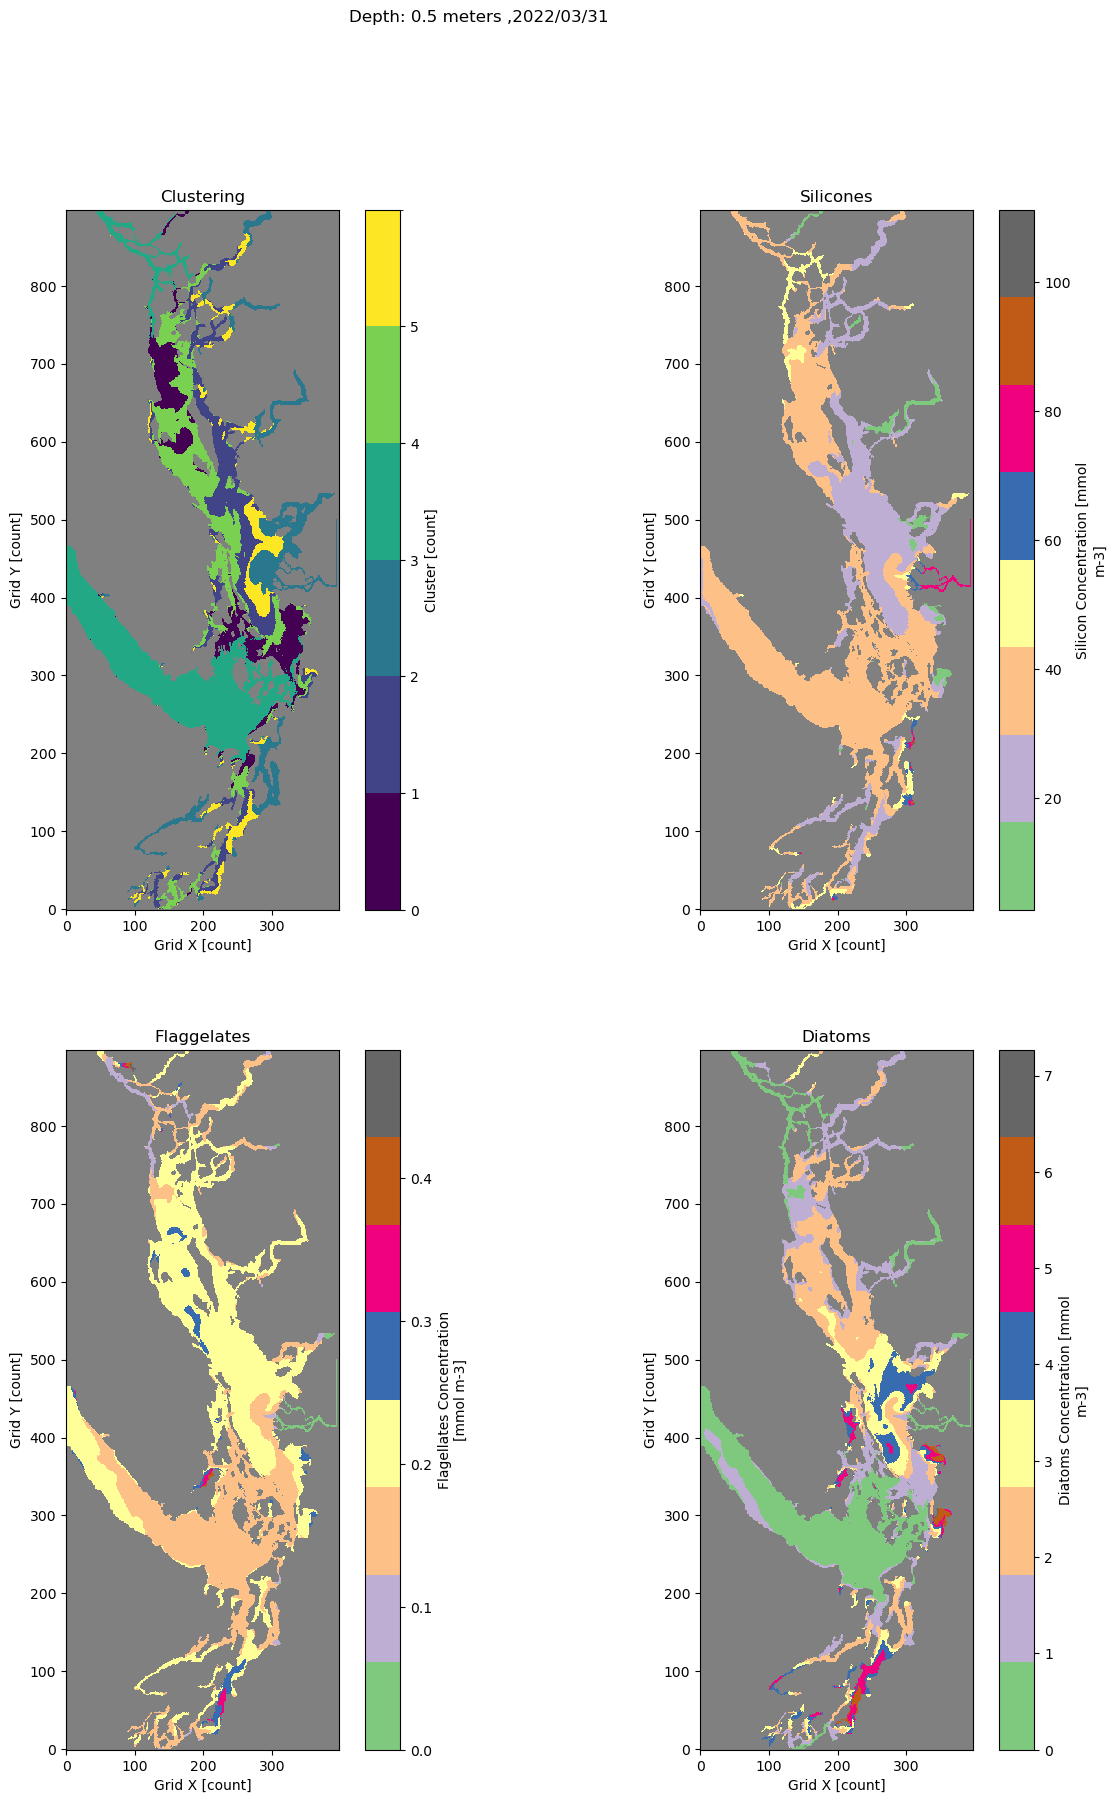

The amount of grid boxes for cluster 0 is 12123 

The minimum temperature for cluster 0 is 7.37 degrees Celsius
The maximum temperature for cluster 0 is 9.88 degrees Celsius
The mean temperature for cluster 0 is 8.5 degrees Celsius 

The minimum salinity for cluster 0 is 28.0 g/kg
The maximum salinity for cluster 0 is 29.27 g/kg
The mean salinity for cluster 0 is 28.52 g/kg 


The amount of grid boxes for cluster 1 is 14049 

The minimum temperature for cluster 1 is 7.61 degrees Celsius
The maximum temperature for cluster 1 is 10.49 degrees Celsius
The mean temperature for cluster 1 is 8.98 degrees Celsius 

The minimum salinity for cluster 1 is 24.75 g/kg
The maximum salinity for cluster 1 is 26.81 g/kg
The mean salinity for cluster 1 is 25.95 g/kg 


The amount of grid boxes for cluster 2 is 9480 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 11.16 degrees Celsius
The mean temperature for cluster 2 is 9.14 degrees Celsius 

Th

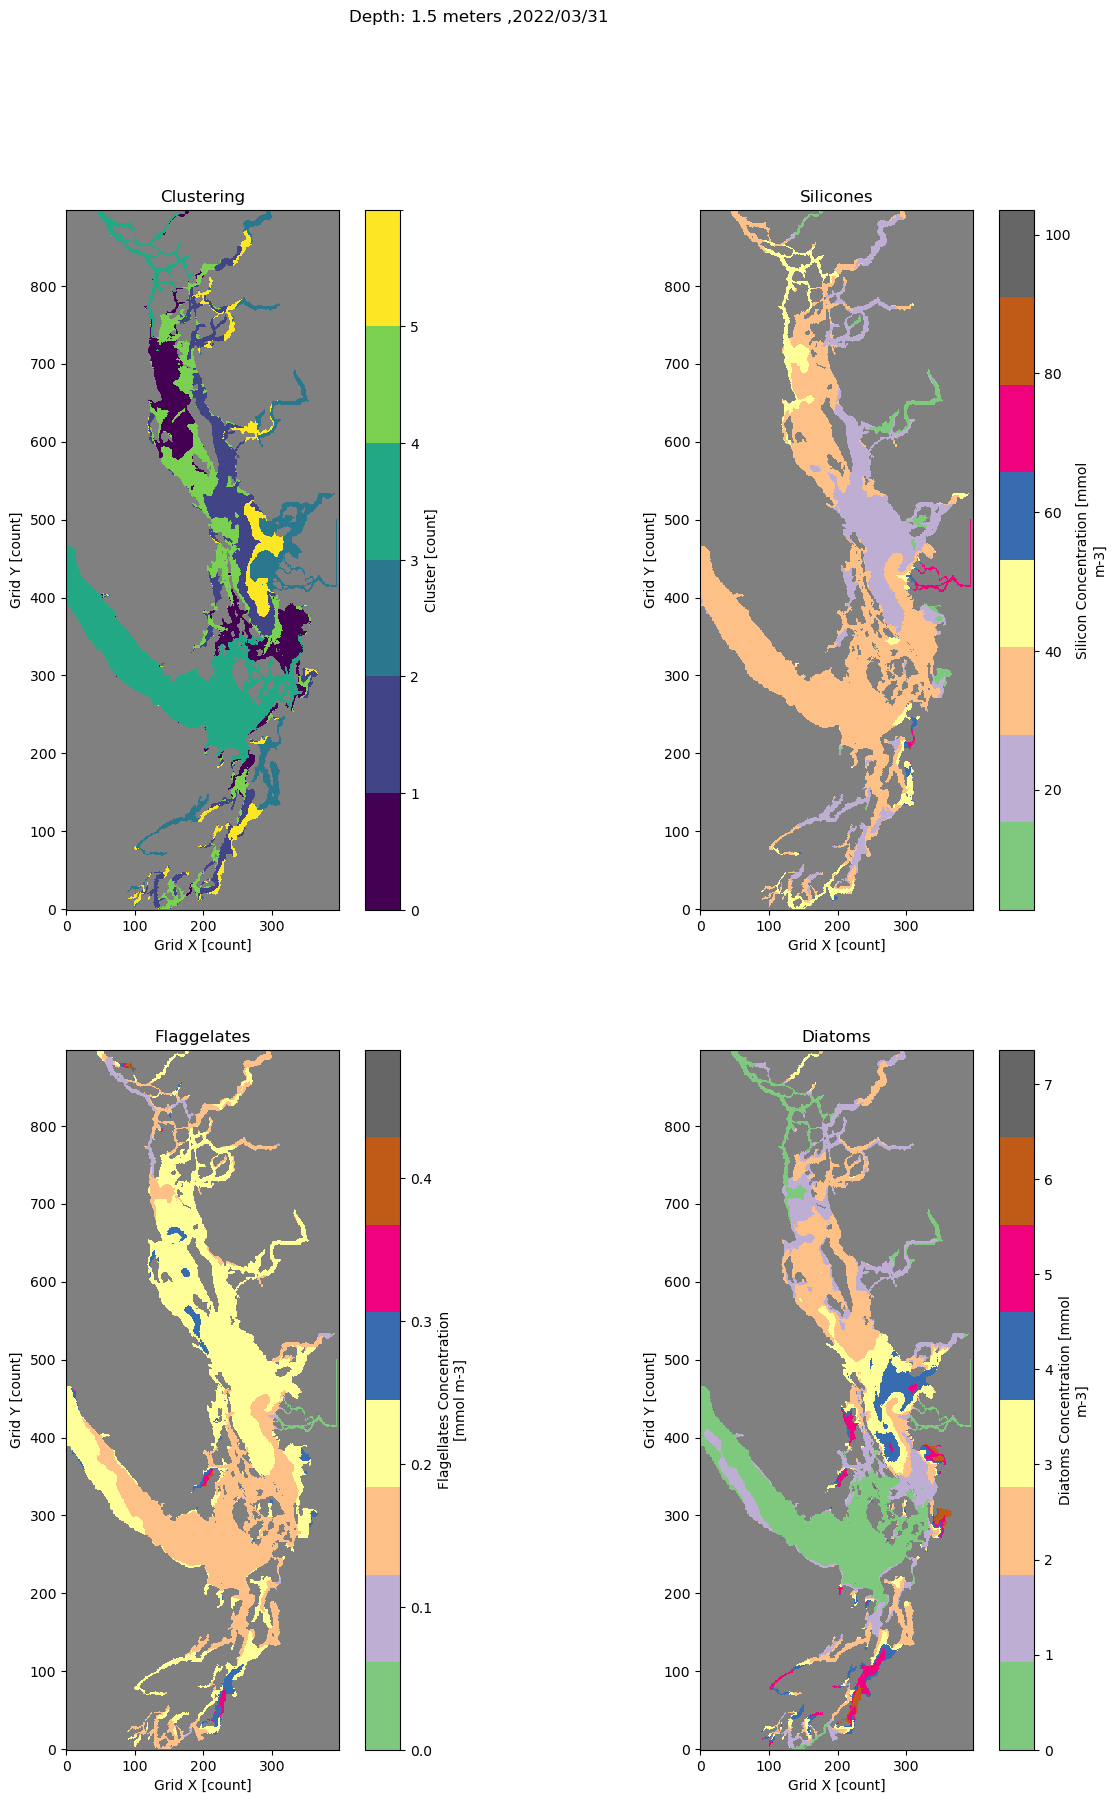

The amount of grid boxes for cluster 0 is 10998 

The minimum temperature for cluster 0 is 7.28 degrees Celsius
The maximum temperature for cluster 0 is 9.79 degrees Celsius
The mean temperature for cluster 0 is 8.41 degrees Celsius 

The minimum salinity for cluster 0 is 28.13 g/kg
The maximum salinity for cluster 0 is 29.37 g/kg
The mean salinity for cluster 0 is 28.64 g/kg 


The amount of grid boxes for cluster 1 is 14459 

The minimum temperature for cluster 1 is 7.48 degrees Celsius
The maximum temperature for cluster 1 is 10.3 degrees Celsius
The mean temperature for cluster 1 is 8.84 degrees Celsius 

The minimum salinity for cluster 1 is 25.36 g/kg
The maximum salinity for cluster 1 is 27.17 g/kg
The mean salinity for cluster 1 is 26.4 g/kg 


The amount of grid boxes for cluster 2 is 8717 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 11.12 degrees Celsius
The mean temperature for cluster 2 is 9.04 degrees Celsius 

Th

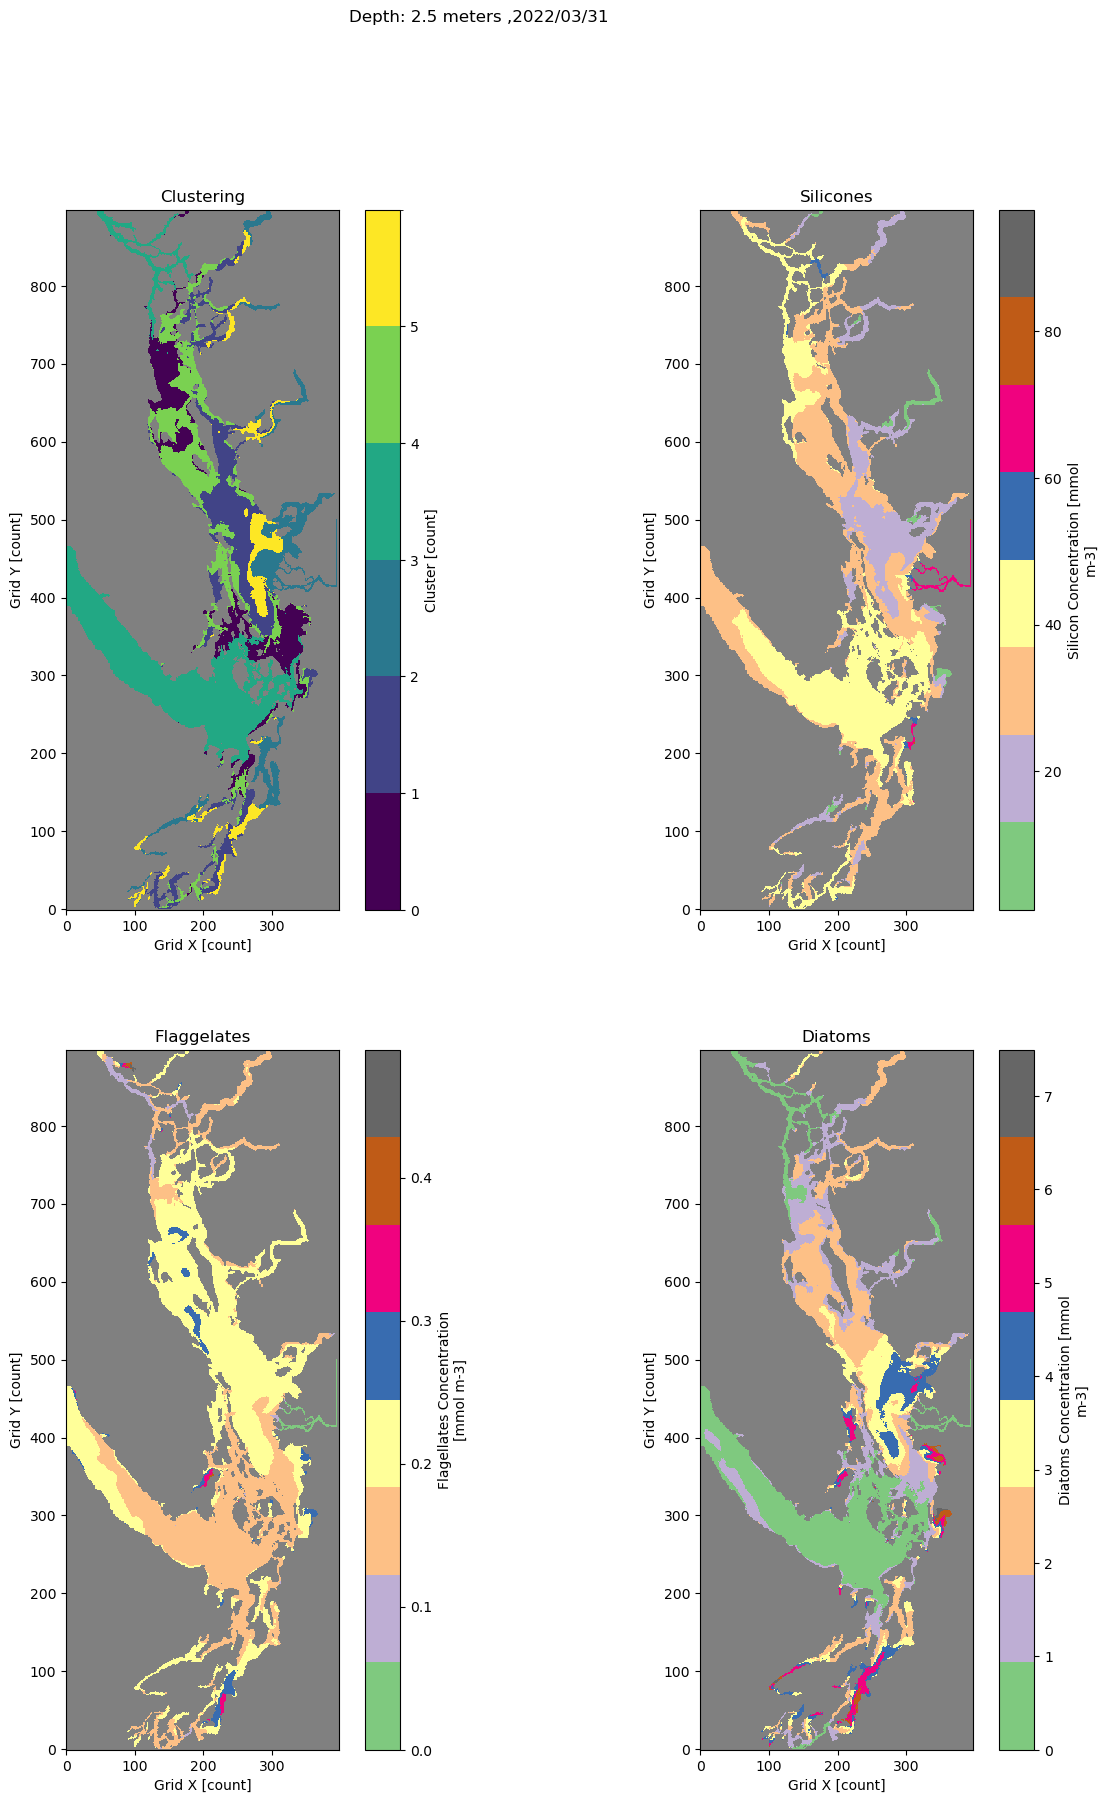

The amount of grid boxes for cluster 0 is 9878 

The minimum temperature for cluster 0 is 7.45 degrees Celsius
The maximum temperature for cluster 0 is 10.4 degrees Celsius
The mean temperature for cluster 0 is 8.85 degrees Celsius 

The minimum salinity for cluster 0 is 25.21 g/kg
The maximum salinity for cluster 0 is 27.02 g/kg
The mean salinity for cluster 0 is 26.17 g/kg 


The amount of grid boxes for cluster 1 is 16141 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 9.71 degrees Celsius
The mean temperature for cluster 1 is 8.44 degrees Celsius 

The minimum salinity for cluster 1 is 27.62 g/kg
The maximum salinity for cluster 1 is 28.85 g/kg
The mean salinity for cluster 1 is 28.15 g/kg 


The amount of grid boxes for cluster 2 is 24532 

The minimum temperature for cluster 2 is 6.71 degrees Celsius
The maximum temperature for cluster 2 is 9.65 degrees Celsius
The mean temperature for cluster 2 is 7.95 degrees Celsius 

Th

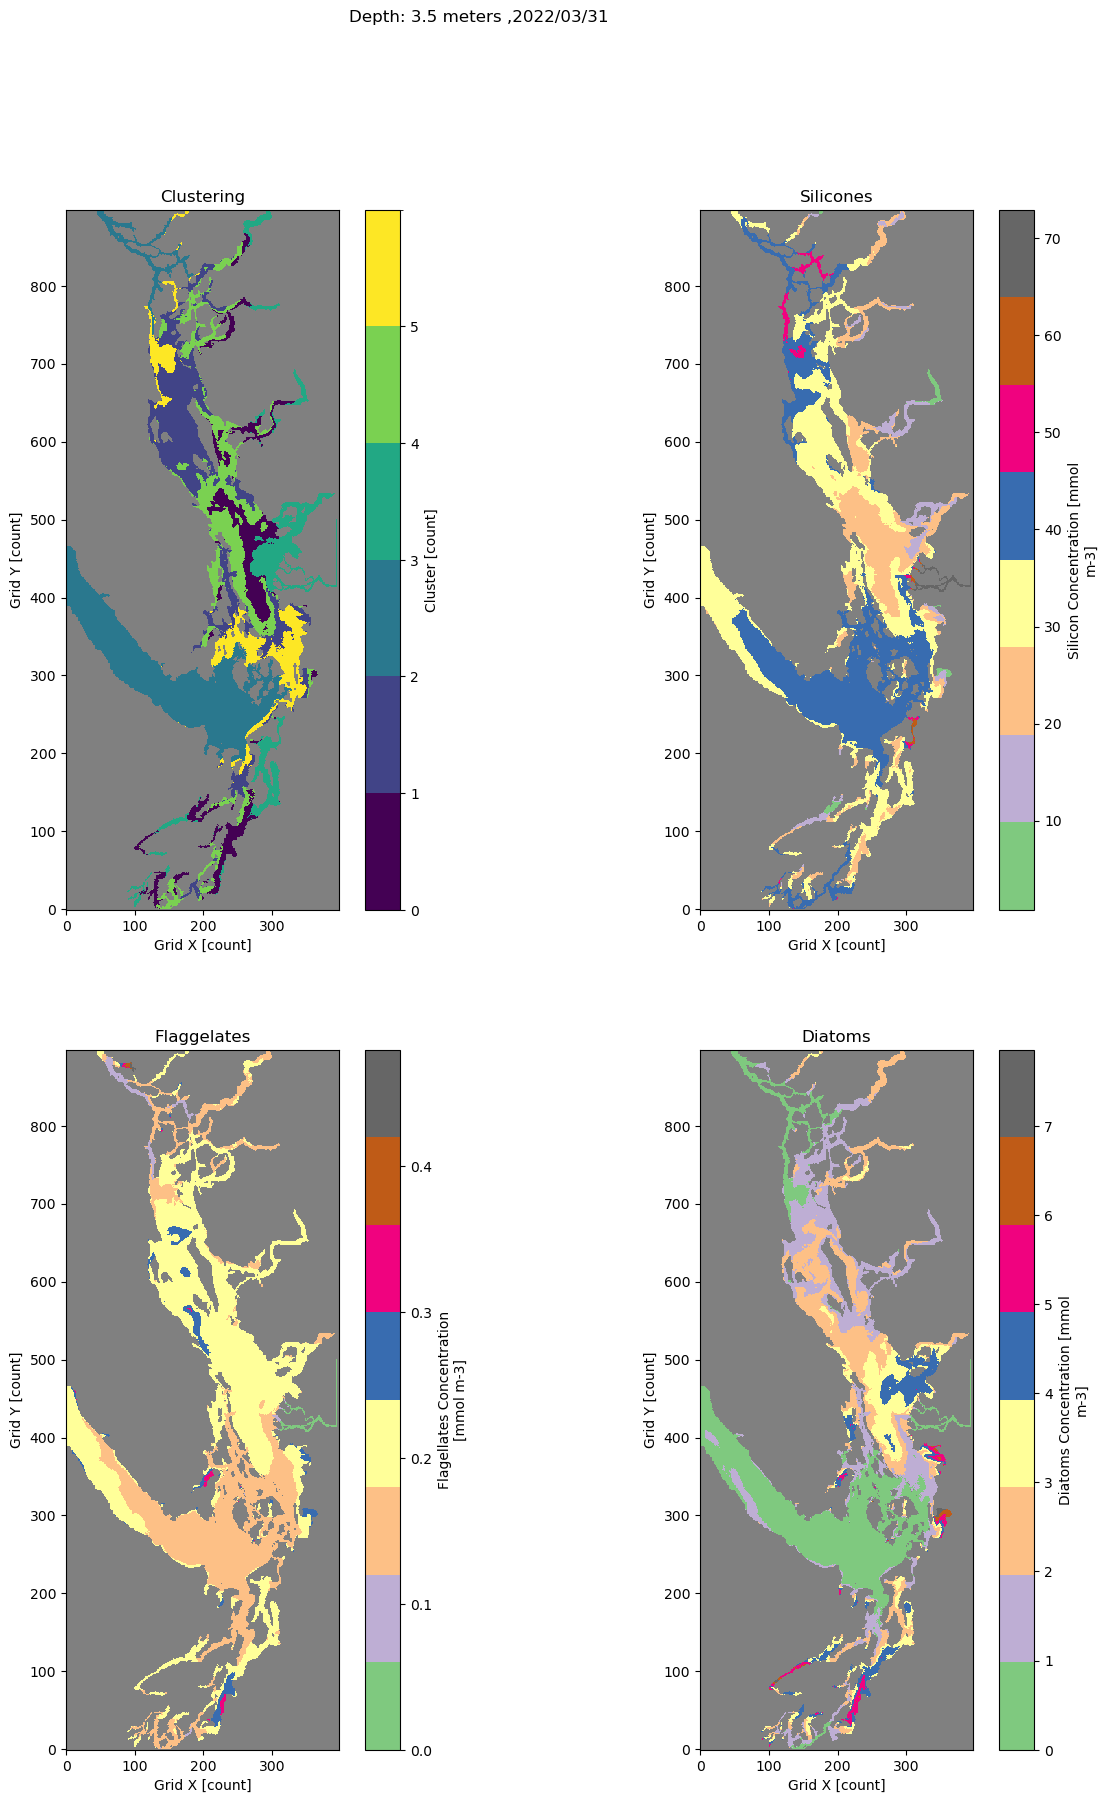

The amount of grid boxes for cluster 0 is 8074 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 10.53 degrees Celsius
The mean temperature for cluster 0 is 8.68 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 26.3 g/kg
The mean salinity for cluster 0 is 22.48 g/kg 


The amount of grid boxes for cluster 1 is 9738 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 9.52 degrees Celsius
The mean temperature for cluster 1 is 8.3 degrees Celsius 

The minimum salinity for cluster 1 is 28.01 g/kg
The maximum salinity for cluster 1 is 28.96 g/kg
The mean salinity for cluster 1 is 28.51 g/kg 


The amount of grid boxes for cluster 2 is 23344 

The minimum temperature for cluster 2 is 6.67 degrees Celsius
The maximum temperature for cluster 2 is 9.26 degrees Celsius
The mean temperature for cluster 2 is 7.93 degrees Celsius 

The mi

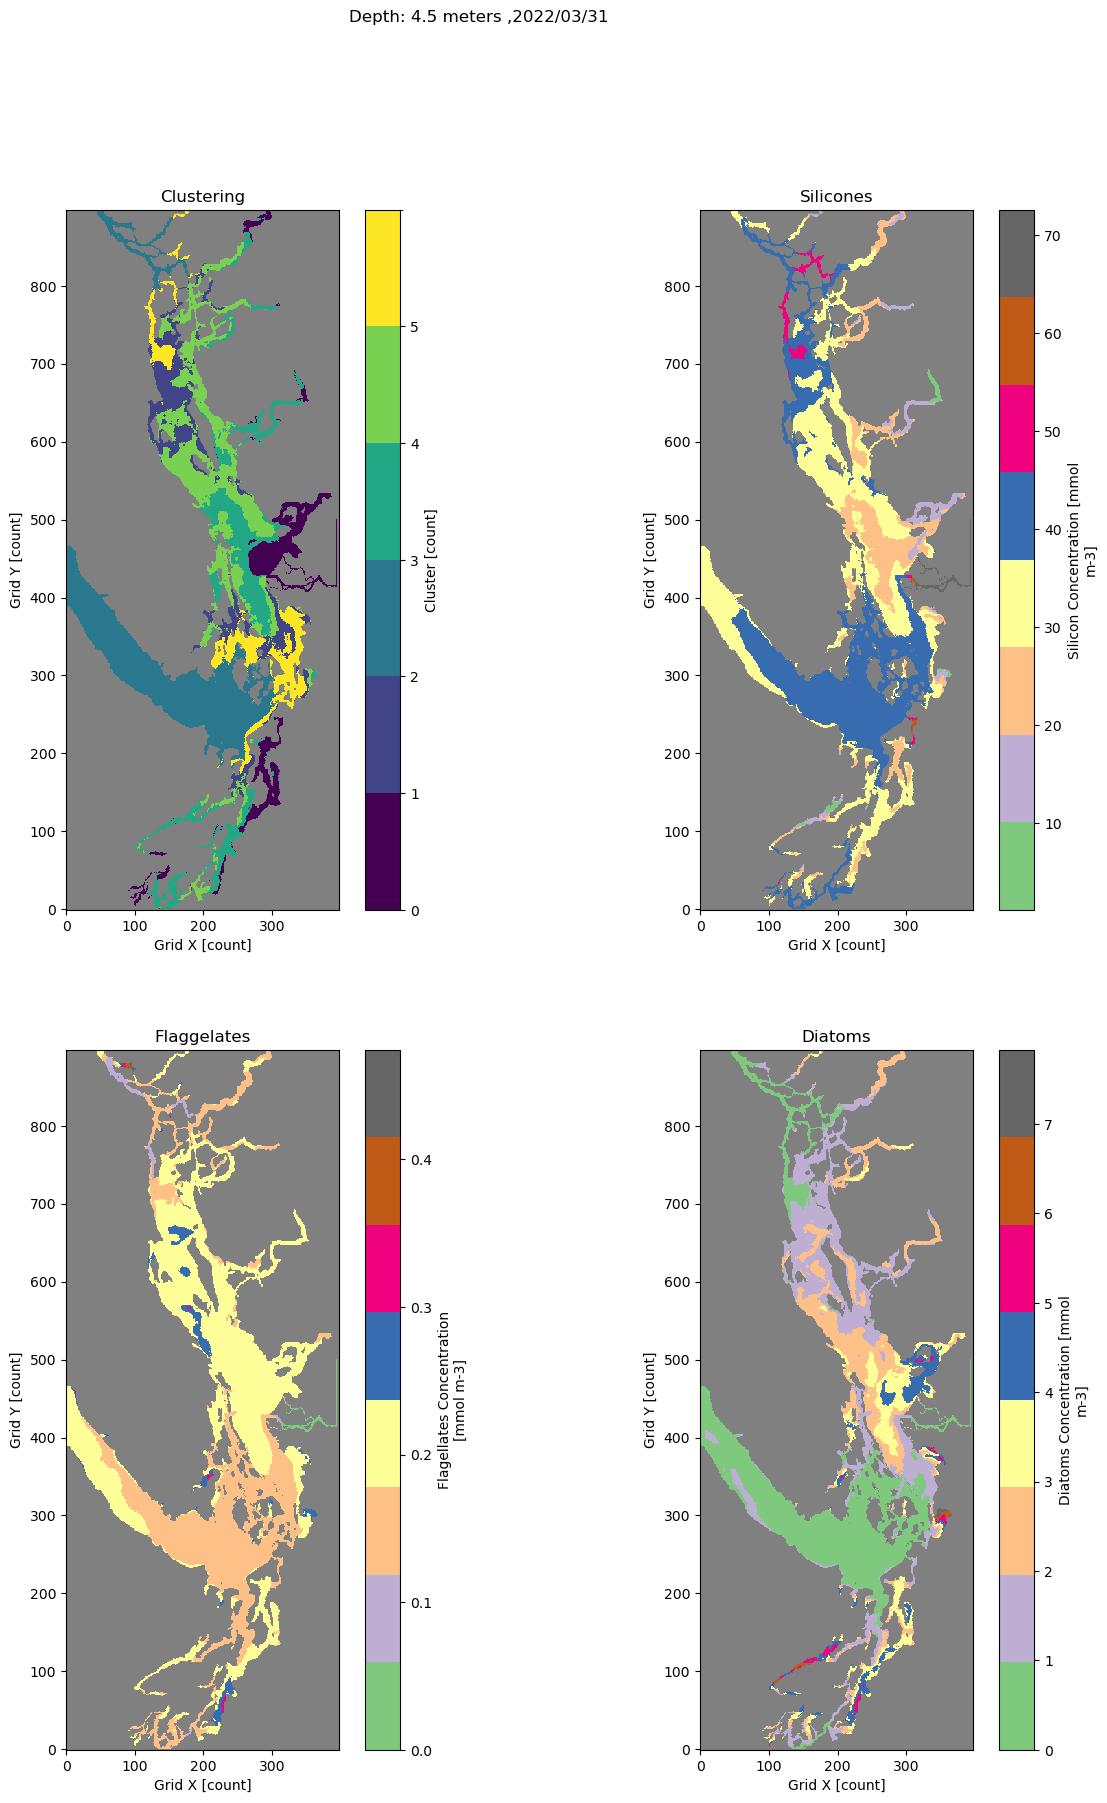

The amount of grid boxes for cluster 0 is 15171 

The minimum temperature for cluster 0 is 7.31 degrees Celsius
The maximum temperature for cluster 0 is 10.37 degrees Celsius
The mean temperature for cluster 0 is 8.41 degrees Celsius 

The minimum salinity for cluster 0 is 26.93 g/kg
The maximum salinity for cluster 0 is 28.04 g/kg
The mean salinity for cluster 0 is 27.4 g/kg 


The amount of grid boxes for cluster 1 is 7780 

The minimum temperature for cluster 1 is 7.82 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.28 degrees Celsius 

The minimum salinity for cluster 1 is 28.42 g/kg
The maximum salinity for cluster 1 is 29.06 g/kg
The mean salinity for cluster 1 is 28.69 g/kg 


The amount of grid boxes for cluster 2 is 23546 

The minimum temperature for cluster 2 is 6.65 degrees Celsius
The maximum temperature for cluster 2 is 9.07 degrees Celsius
The mean temperature for cluster 2 is 7.92 degrees Celsius 

T

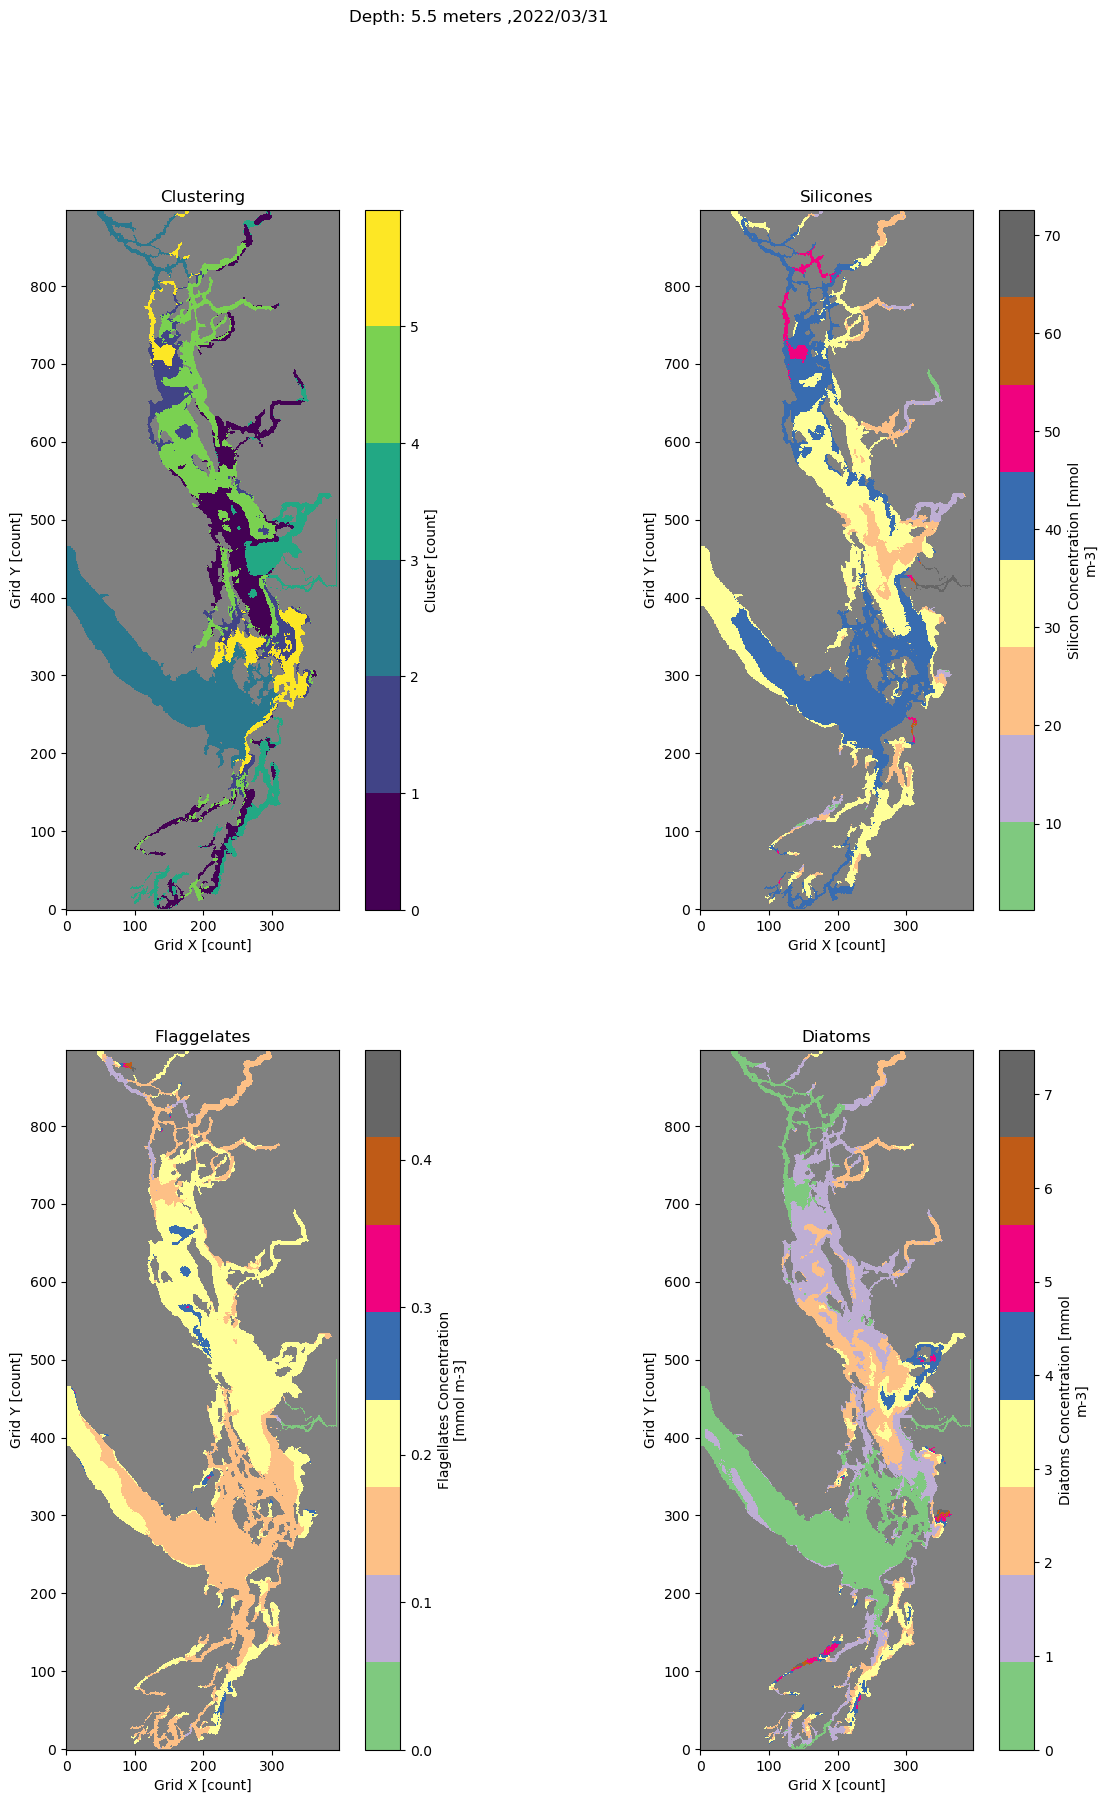

The amount of grid boxes for cluster 0 is 16443 

The minimum temperature for cluster 0 is 7.3 degrees Celsius
The maximum temperature for cluster 0 is 10.32 degrees Celsius
The mean temperature for cluster 0 is 8.29 degrees Celsius 

The minimum salinity for cluster 0 is 27.22 g/kg
The maximum salinity for cluster 0 is 28.46 g/kg
The mean salinity for cluster 0 is 27.79 g/kg 


The amount of grid boxes for cluster 1 is 16848 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 10.2 degrees Celsius
The mean temperature for cluster 1 is 8.11 degrees Celsius 

The minimum salinity for cluster 1 is 27.99 g/kg
The maximum salinity for cluster 1 is 28.7 g/kg
The mean salinity for cluster 1 is 28.38 g/kg 


The amount of grid boxes for cluster 2 is 7001 

The minimum temperature for cluster 2 is 6.32 degrees Celsius
The maximum temperature for cluster 2 is 9.04 degrees Celsius
The mean temperature for cluster 2 is 8.03 degrees Celsius 

The

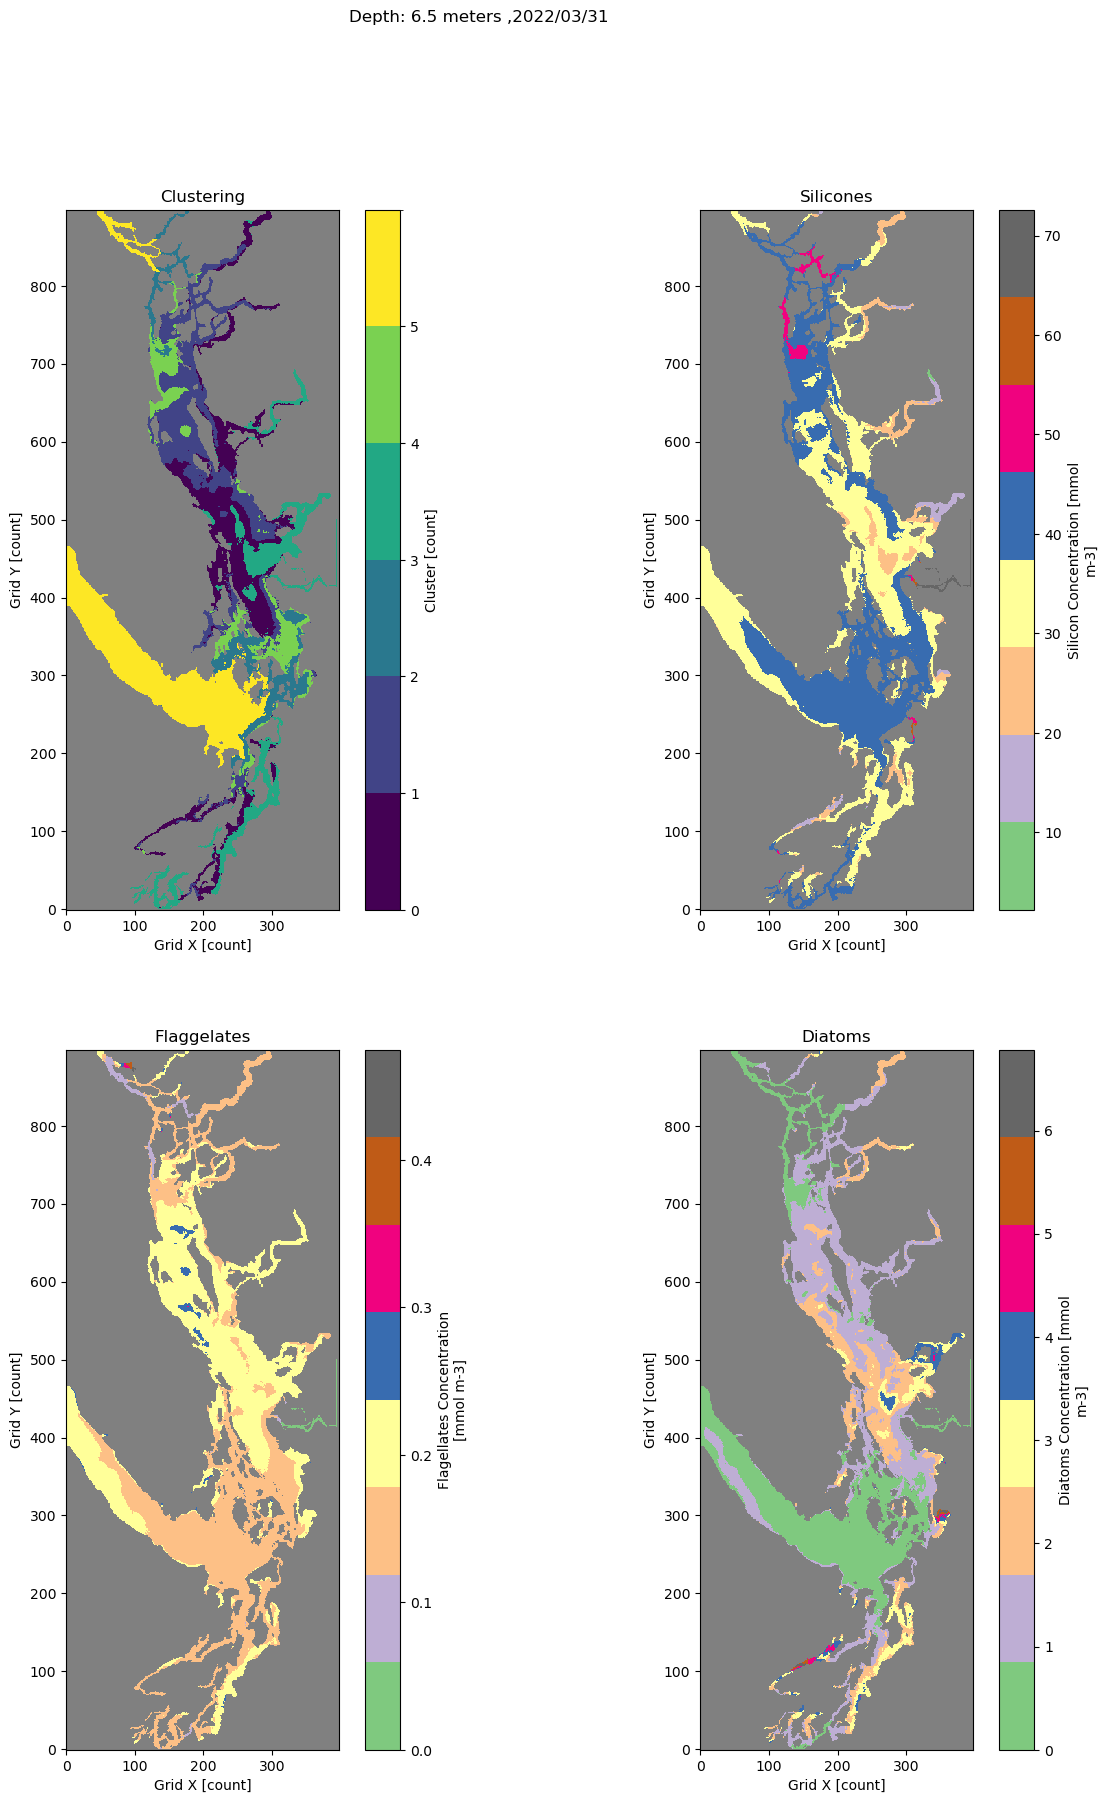

The amount of grid boxes for cluster 0 is 4796 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 9.7 degrees Celsius
The mean temperature for cluster 0 is 8.39 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 27.34 g/kg
The mean salinity for cluster 0 is 24.61 g/kg 


The amount of grid boxes for cluster 1 is 11182 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 8.33 degrees Celsius
The mean temperature for cluster 1 is 7.94 degrees Celsius 

The minimum salinity for cluster 1 is 28.1 g/kg
The maximum salinity for cluster 1 is 29.16 g/kg
The mean salinity for cluster 1 is 28.63 g/kg 


The amount of grid boxes for cluster 2 is 20869 

The minimum temperature for cluster 2 is 6.72 degrees Celsius
The maximum temperature for cluster 2 is 8.76 degrees Celsius
The mean temperature for cluster 2 is 7.89 degrees Celsius 

The mi

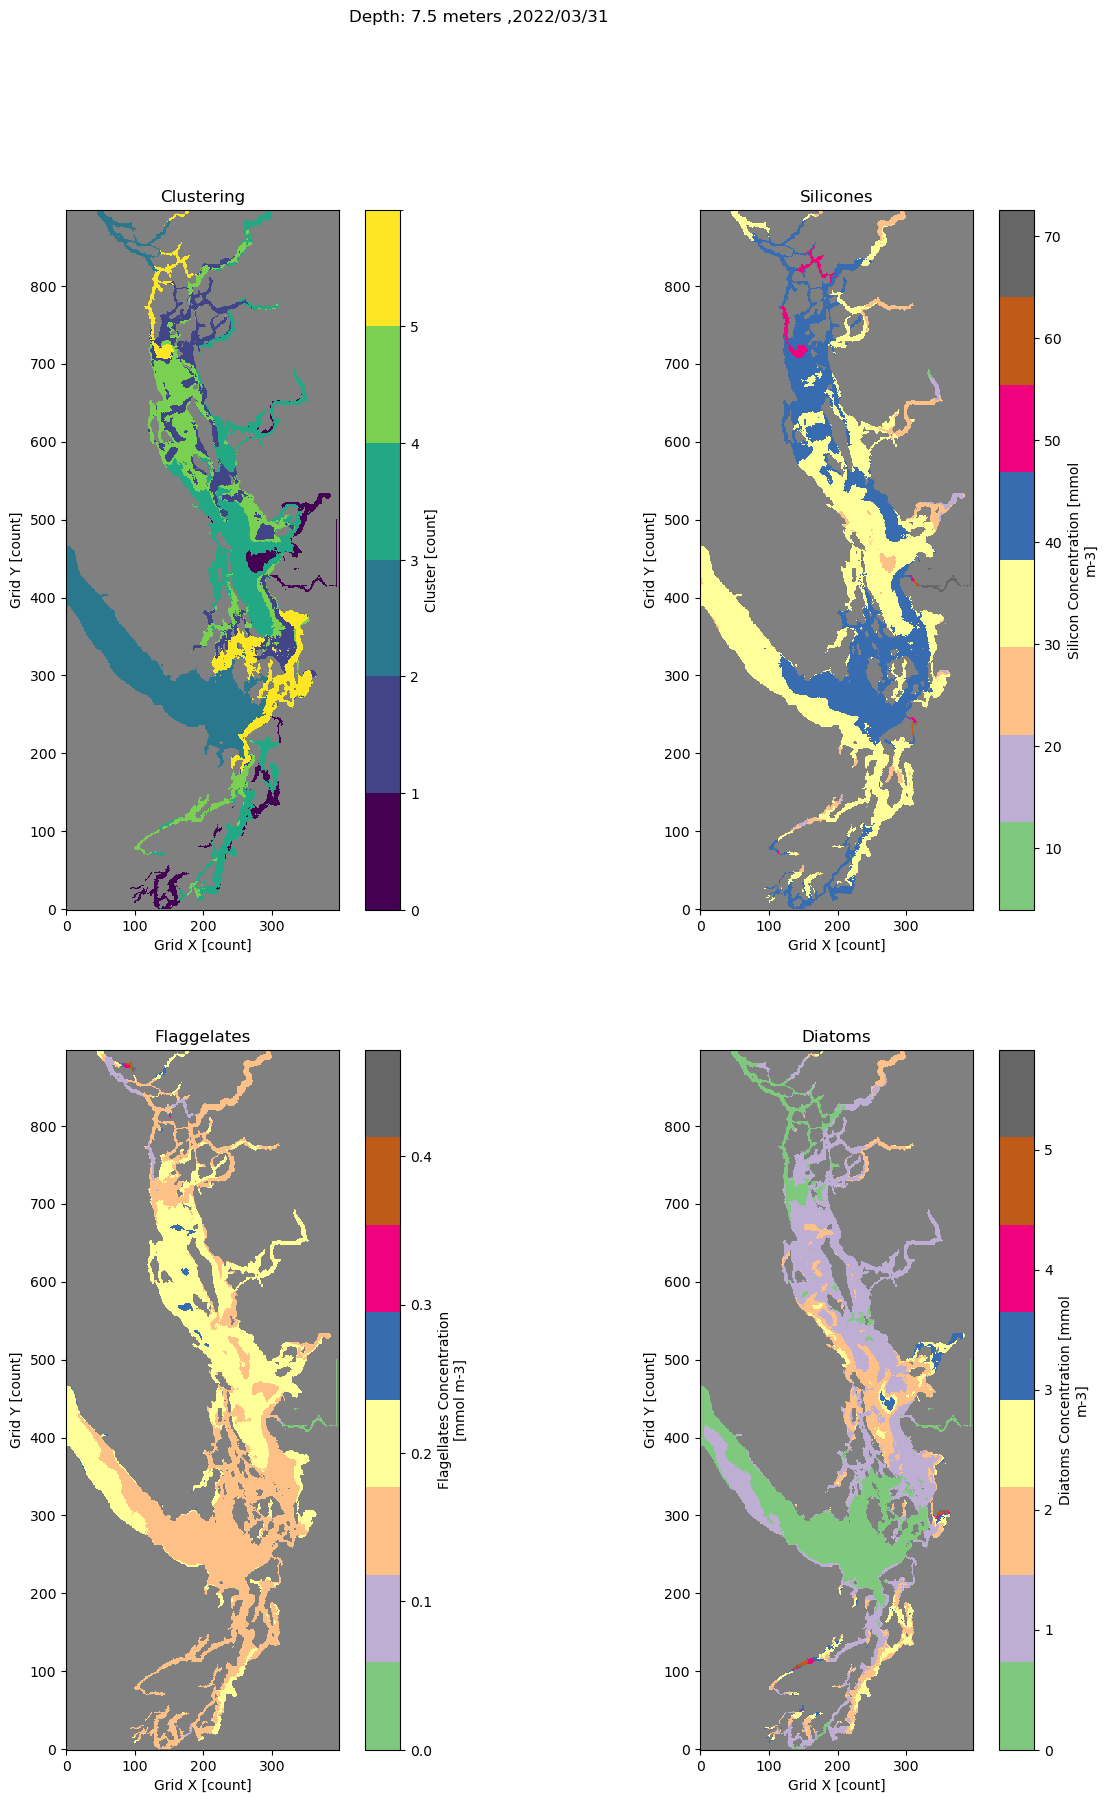

The amount of grid boxes for cluster 0 is 7664 

The minimum temperature for cluster 0 is 6.15 degrees Celsius
The maximum temperature for cluster 0 is 8.84 degrees Celsius
The mean temperature for cluster 0 is 8.01 degrees Celsius 

The minimum salinity for cluster 0 is 29.15 g/kg
The maximum salinity for cluster 0 is 29.88 g/kg
The mean salinity for cluster 0 is 29.52 g/kg 


The amount of grid boxes for cluster 1 is 18977 

The minimum temperature for cluster 1 is 7.42 degrees Celsius
The maximum temperature for cluster 1 is 9.5 degrees Celsius
The mean temperature for cluster 1 is 8.01 degrees Celsius 

The minimum salinity for cluster 1 is 28.19 g/kg
The maximum salinity for cluster 1 is 28.79 g/kg
The mean salinity for cluster 1 is 28.45 g/kg 


The amount of grid boxes for cluster 2 is 17436 

The minimum temperature for cluster 2 is 7.36 degrees Celsius
The maximum temperature for cluster 2 is 9.86 degrees Celsius
The mean temperature for cluster 2 is 8.26 degrees Celsius 

The

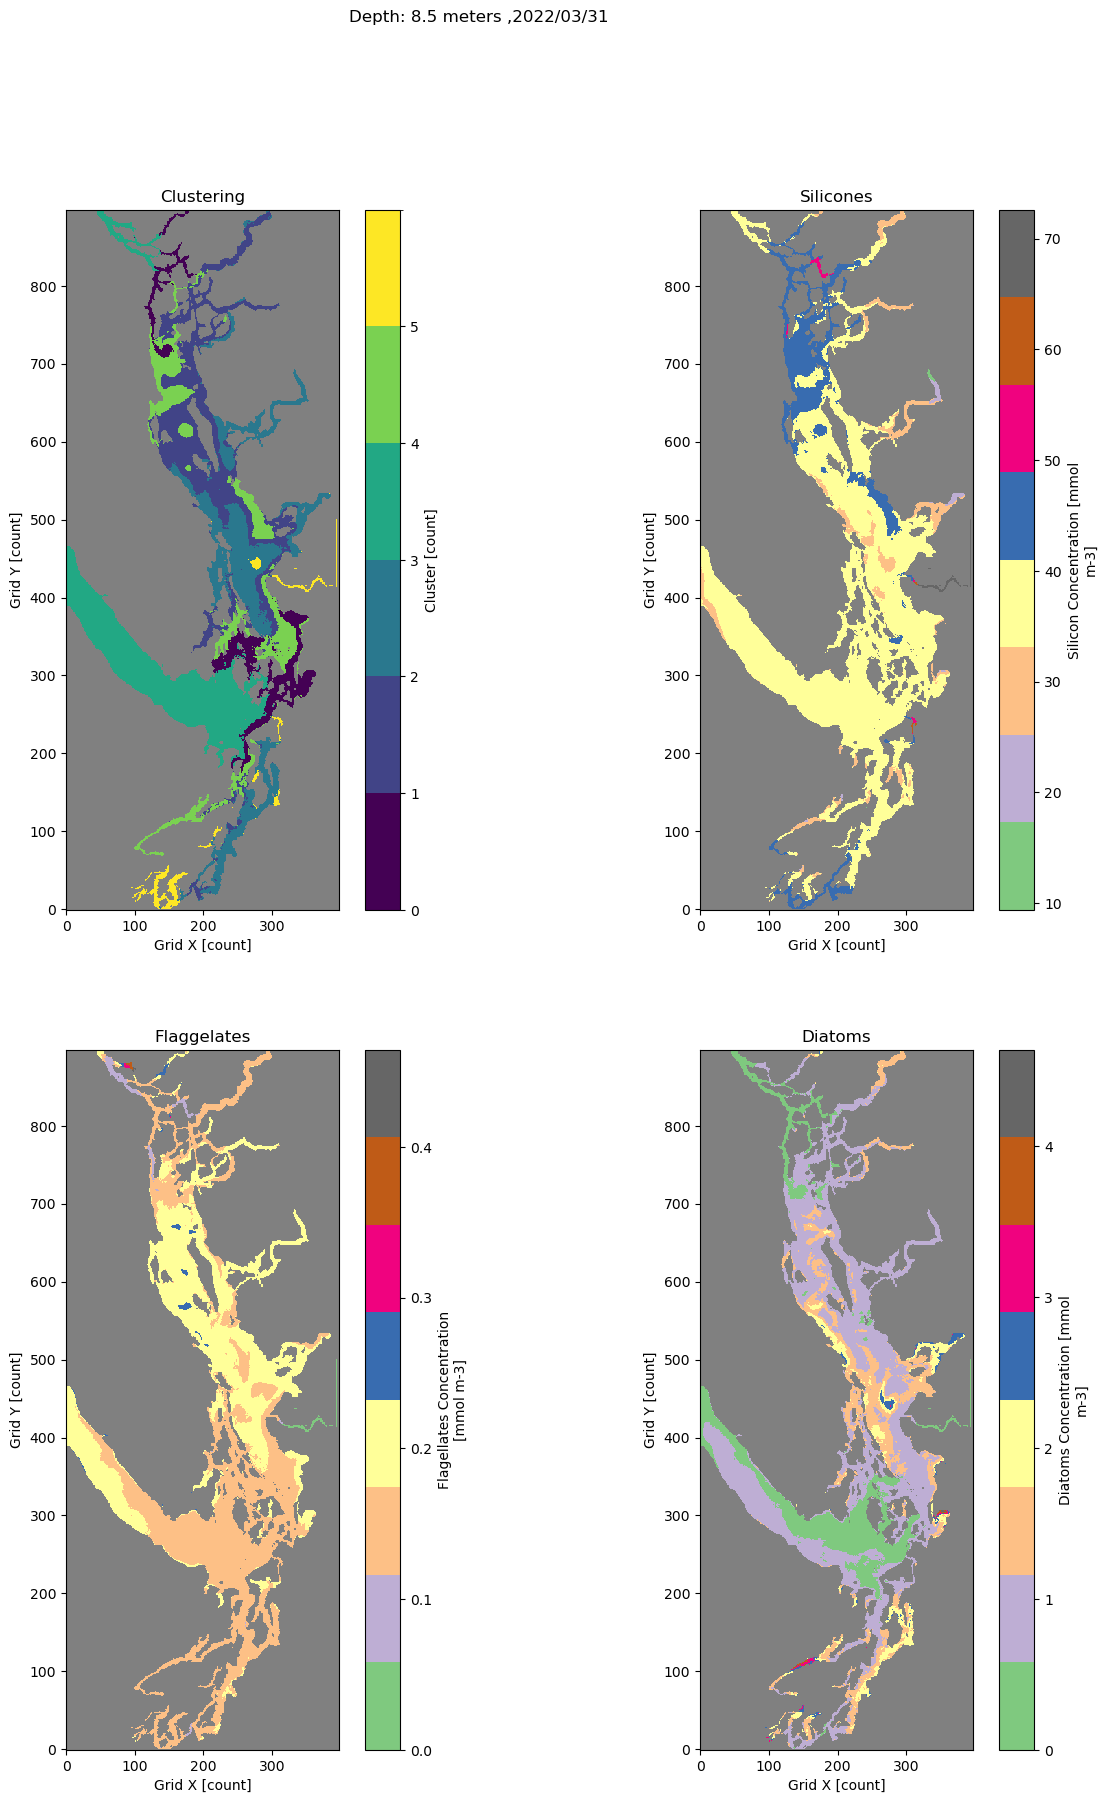

The amount of grid boxes for cluster 0 is 6749 

The minimum temperature for cluster 0 is 6.16 degrees Celsius
The maximum temperature for cluster 0 is 8.63 degrees Celsius
The mean temperature for cluster 0 is 7.91 degrees Celsius 

The minimum salinity for cluster 0 is 29.51 g/kg
The maximum salinity for cluster 0 is 30.2 g/kg
The mean salinity for cluster 0 is 29.88 g/kg 


The amount of grid boxes for cluster 1 is 14767 

The minimum temperature for cluster 1 is 7.55 degrees Celsius
The maximum temperature for cluster 1 is 10.22 degrees Celsius
The mean temperature for cluster 1 is 8.17 degrees Celsius 

The minimum salinity for cluster 1 is 28.59 g/kg
The maximum salinity for cluster 1 is 29.16 g/kg
The mean salinity for cluster 1 is 28.81 g/kg 


The amount of grid boxes for cluster 2 is 22726 

The minimum temperature for cluster 2 is 7.39 degrees Celsius
The maximum temperature for cluster 2 is 10.25 degrees Celsius
The mean temperature for cluster 2 is 8.05 degrees Celsius 

T

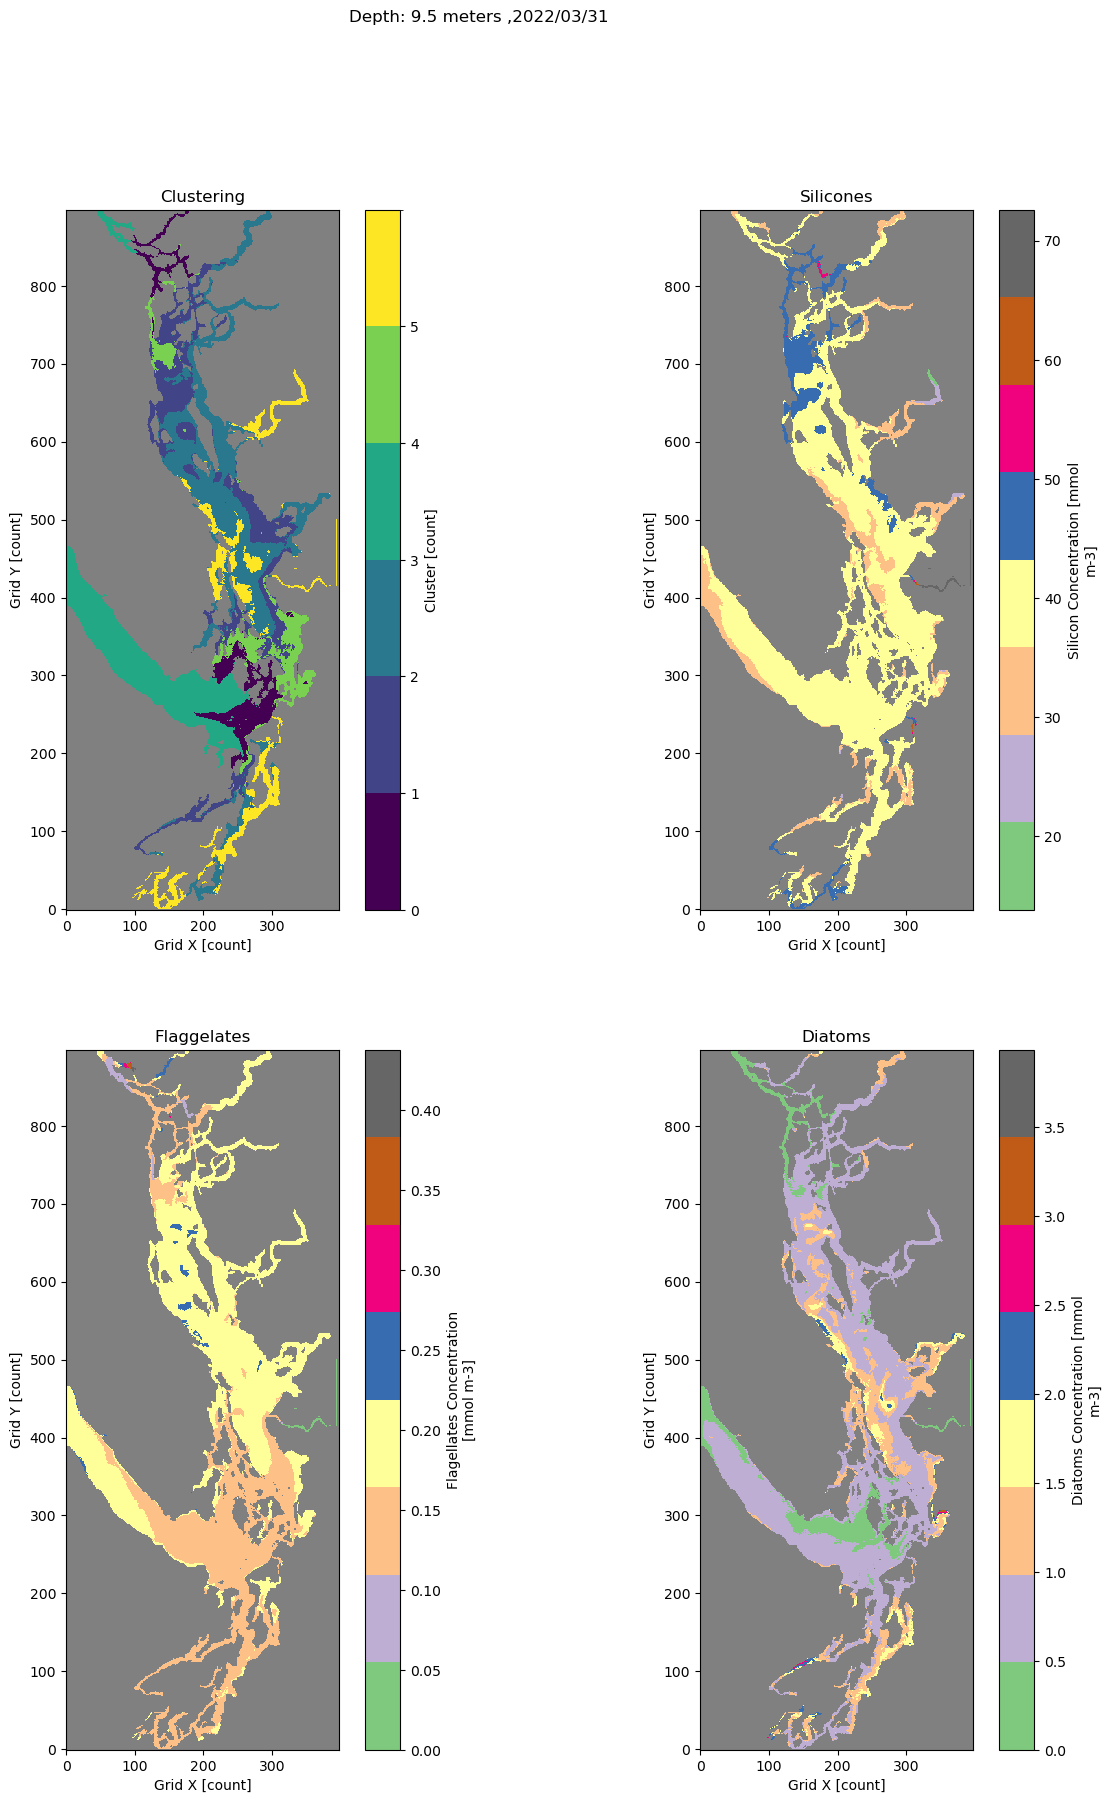

The amount of grid boxes for cluster 0 is 22327 

The minimum temperature for cluster 0 is 7.38 degrees Celsius
The maximum temperature for cluster 0 is 8.32 degrees Celsius
The mean temperature for cluster 0 is 7.91 degrees Celsius 

The minimum salinity for cluster 0 is 27.69 g/kg
The maximum salinity for cluster 0 is 28.85 g/kg
The mean salinity for cluster 0 is 28.51 g/kg 


The amount of grid boxes for cluster 1 is 5640 

The minimum temperature for cluster 1 is 7.55 degrees Celsius
The maximum temperature for cluster 1 is 8.64 degrees Celsius
The mean temperature for cluster 1 is 8.04 degrees Celsius 

The minimum salinity for cluster 1 is 29.07 g/kg
The maximum salinity for cluster 1 is 29.66 g/kg
The mean salinity for cluster 1 is 29.43 g/kg 


The amount of grid boxes for cluster 2 is 17325 

The minimum temperature for cluster 2 is 7.32 degrees Celsius
The maximum temperature for cluster 2 is 8.33 degrees Celsius
The mean temperature for cluster 2 is 7.86 degrees Celsius 

Th

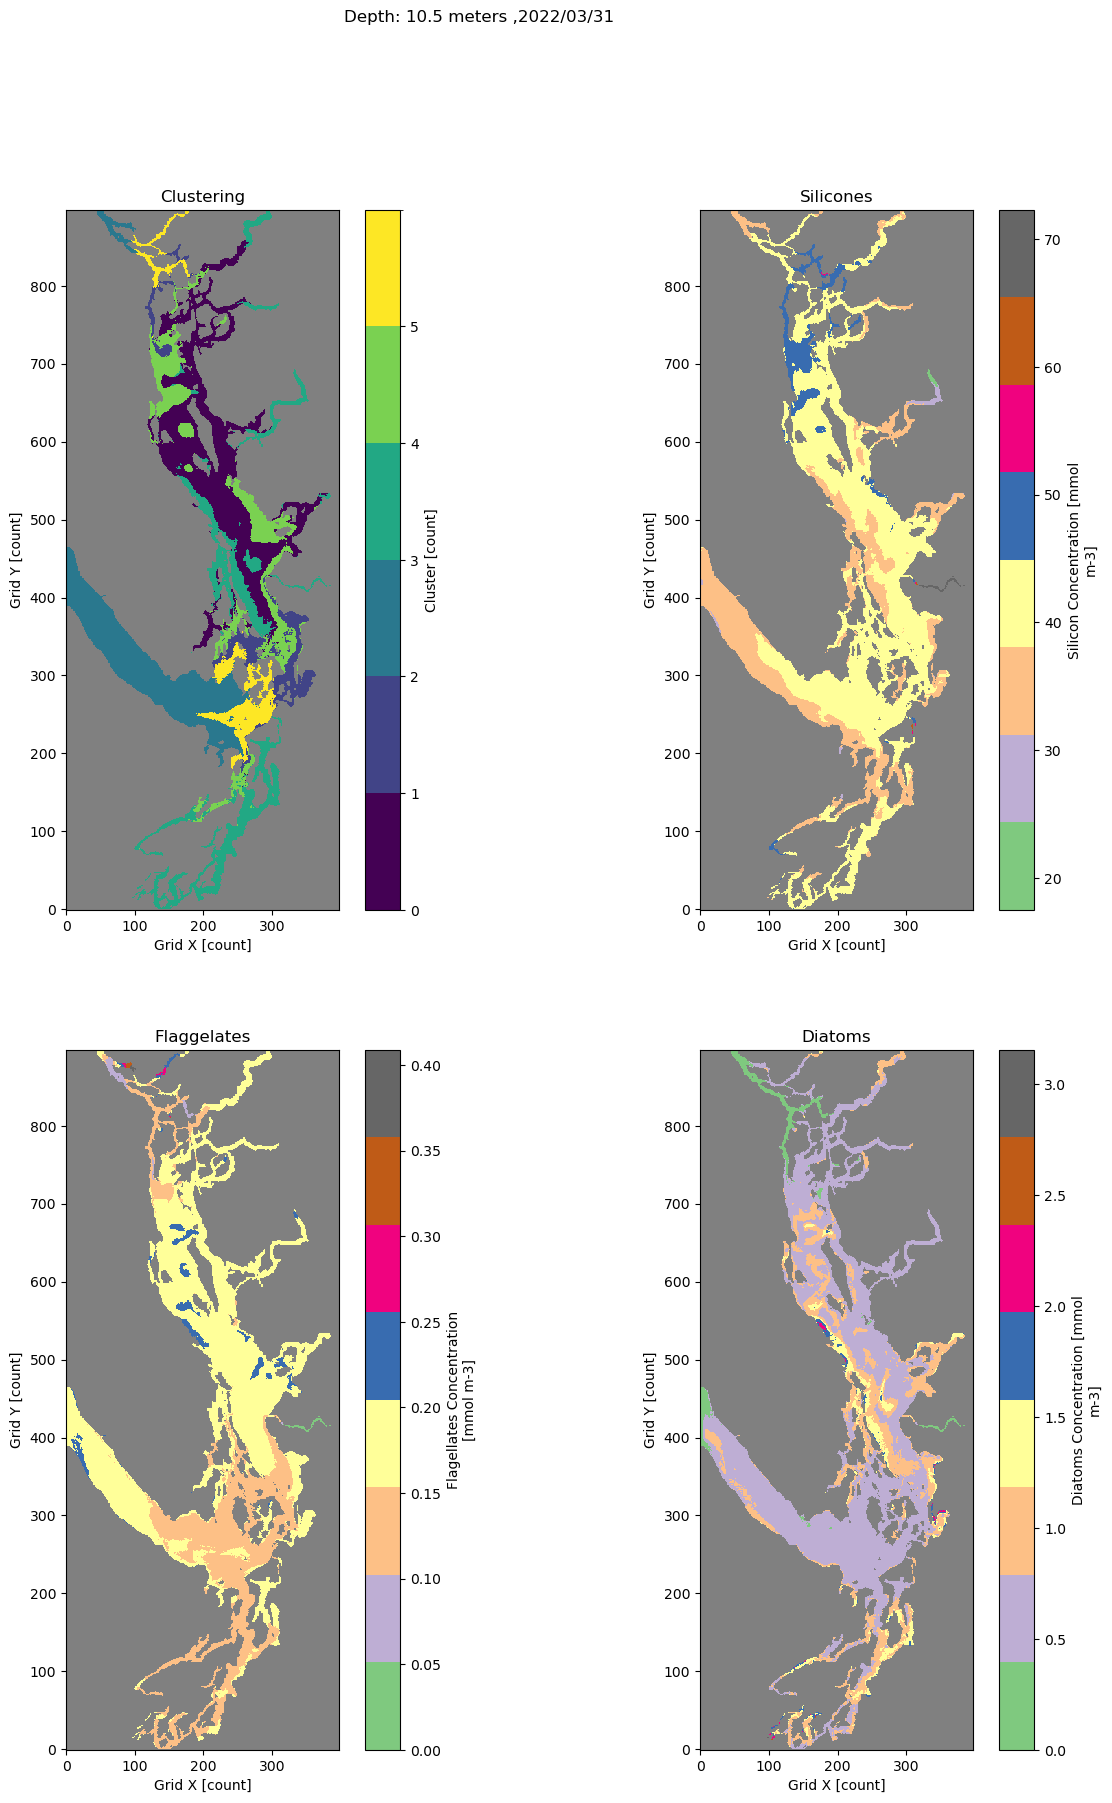

The amount of grid boxes for cluster 0 is 19294 

The minimum temperature for cluster 0 is 7.37 degrees Celsius
The maximum temperature for cluster 0 is 9.98 degrees Celsius
The mean temperature for cluster 0 is 8.09 degrees Celsius 

The minimum salinity for cluster 0 is 27.93 g/kg
The maximum salinity for cluster 0 is 28.64 g/kg
The mean salinity for cluster 0 is 28.4 g/kg 


The amount of grid boxes for cluster 1 is 6935 

The minimum temperature for cluster 1 is 7.54 degrees Celsius
The maximum temperature for cluster 1 is 8.62 degrees Celsius
The mean temperature for cluster 1 is 8.09 degrees Celsius 

The minimum salinity for cluster 1 is 29.05 g/kg
The maximum salinity for cluster 1 is 29.62 g/kg
The mean salinity for cluster 1 is 29.31 g/kg 


The amount of grid boxes for cluster 2 is 18820 

The minimum temperature for cluster 2 is 7.28 degrees Celsius
The maximum temperature for cluster 2 is 8.33 degrees Celsius
The mean temperature for cluster 2 is 7.86 degrees Celsius 

The

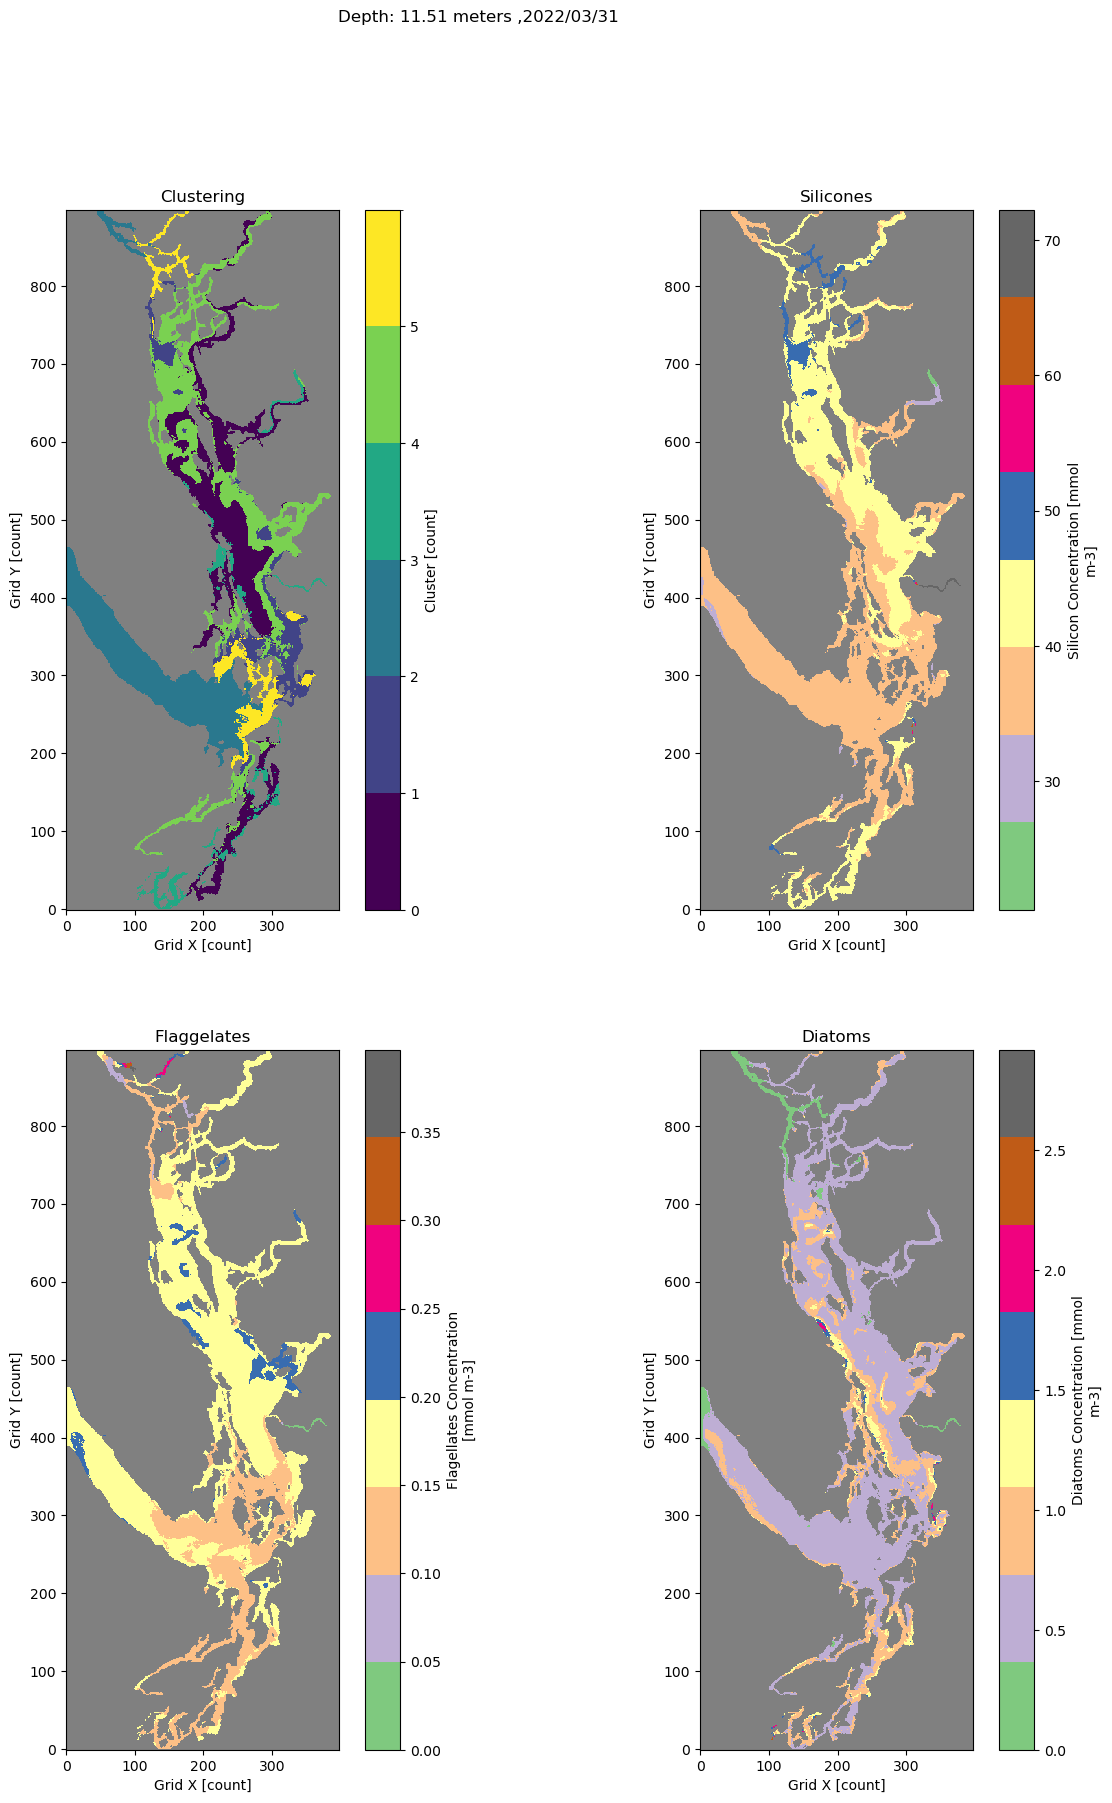

The amount of grid boxes for cluster 0 is 5586 

The minimum temperature for cluster 0 is 6.45 degrees Celsius
The maximum temperature for cluster 0 is 8.65 degrees Celsius
The mean temperature for cluster 0 is 7.89 degrees Celsius 

The minimum salinity for cluster 0 is 29.64 g/kg
The maximum salinity for cluster 0 is 30.21 g/kg
The mean salinity for cluster 0 is 29.95 g/kg 


The amount of grid boxes for cluster 1 is 11860 

The minimum temperature for cluster 1 is 7.8 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.24 degrees Celsius 

The minimum salinity for cluster 1 is 28.9 g/kg
The maximum salinity for cluster 1 is 29.4 g/kg
The mean salinity for cluster 1 is 29.1 g/kg 


The amount of grid boxes for cluster 2 is 19192 

The minimum temperature for cluster 2 is 7.37 degrees Celsius
The maximum temperature for cluster 2 is 8.55 degrees Celsius
The mean temperature for cluster 2 is 7.94 degrees Celsius 

The m

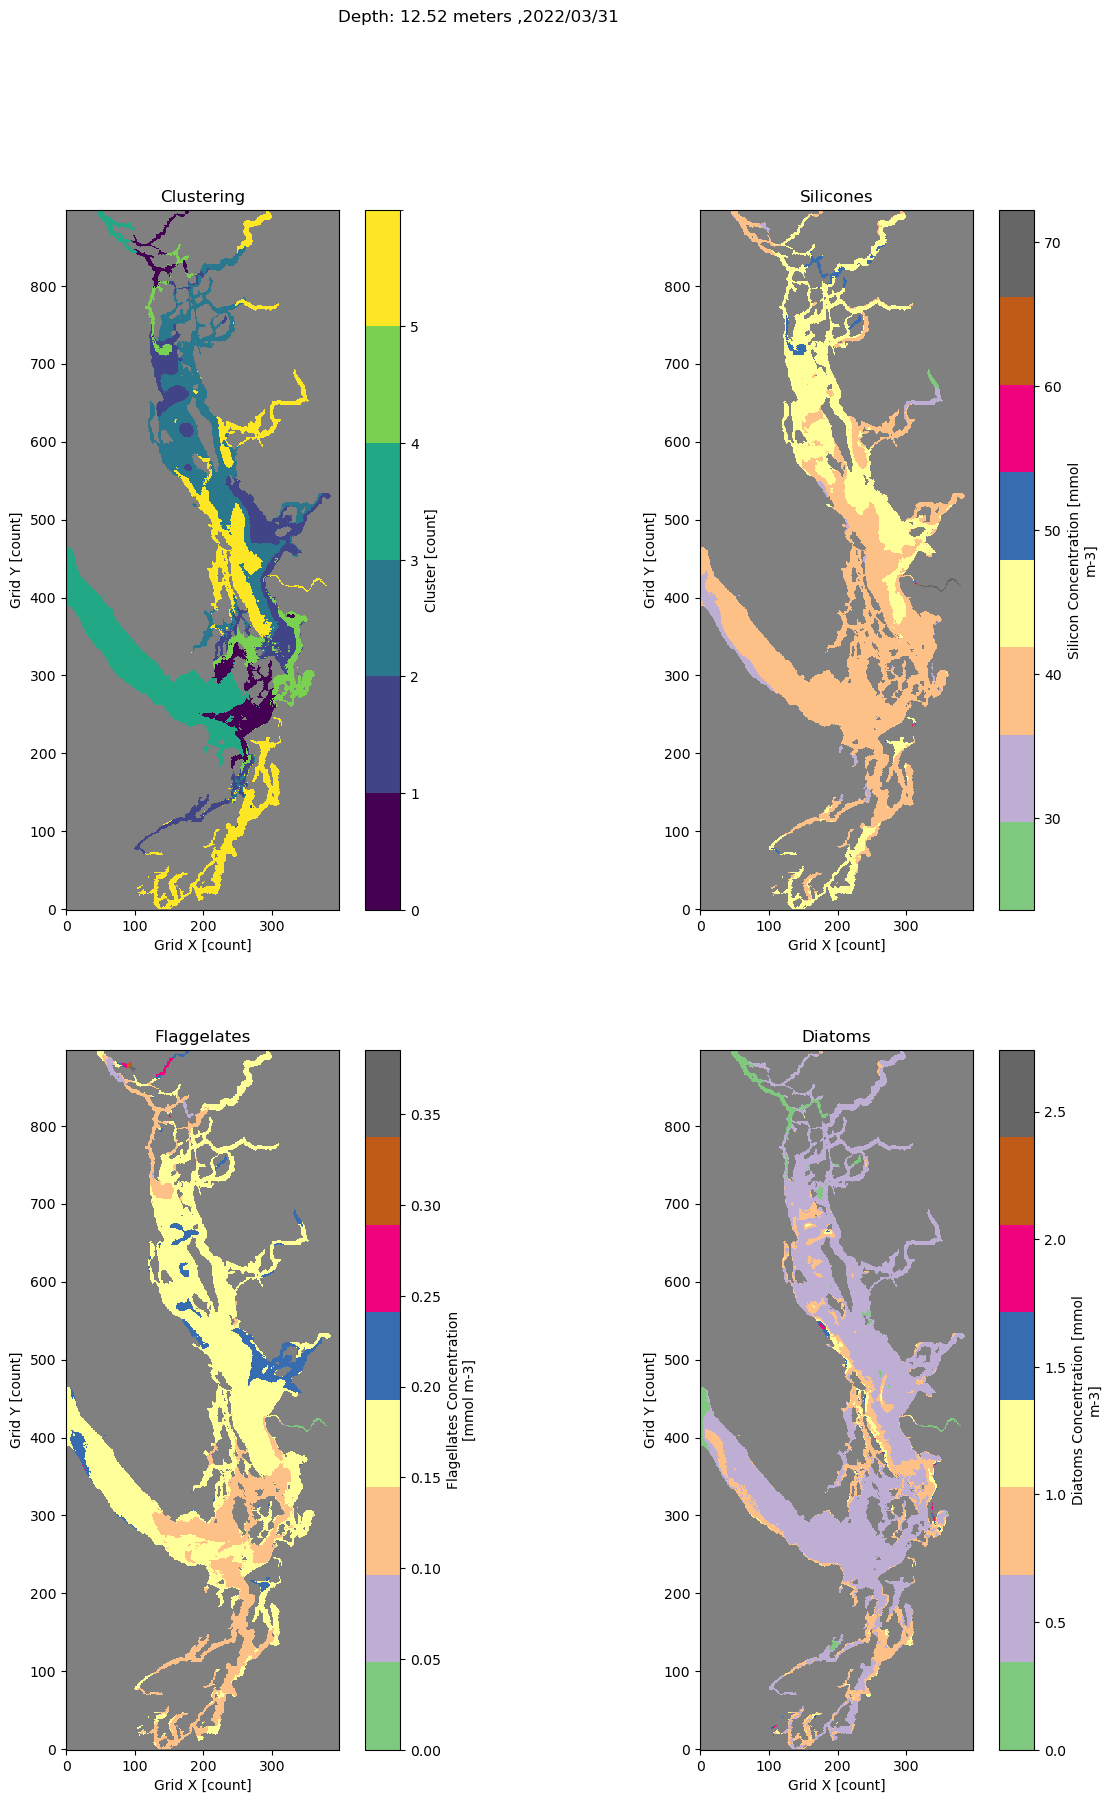

The amount of grid boxes for cluster 0 is 20903 

The minimum temperature for cluster 0 is 6.42 degrees Celsius
The maximum temperature for cluster 0 is 9.15 degrees Celsius
The mean temperature for cluster 0 is 7.98 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 28.86 g/kg
The mean salinity for cluster 0 is 28.34 g/kg 


The amount of grid boxes for cluster 1 is 17640 

The minimum temperature for cluster 1 is 7.63 degrees Celsius
The maximum temperature for cluster 1 is 8.53 degrees Celsius
The mean temperature for cluster 1 is 8.09 degrees Celsius 

The minimum salinity for cluster 1 is 28.76 g/kg
The maximum salinity for cluster 1 is 29.36 g/kg
The mean salinity for cluster 1 is 29.04 g/kg 


The amount of grid boxes for cluster 2 is 5531 

The minimum temperature for cluster 2 is 6.56 degrees Celsius
The maximum temperature for cluster 2 is 8.31 degrees Celsius
The mean temperature for cluster 2 is 7.86 degrees Celsius 

The 

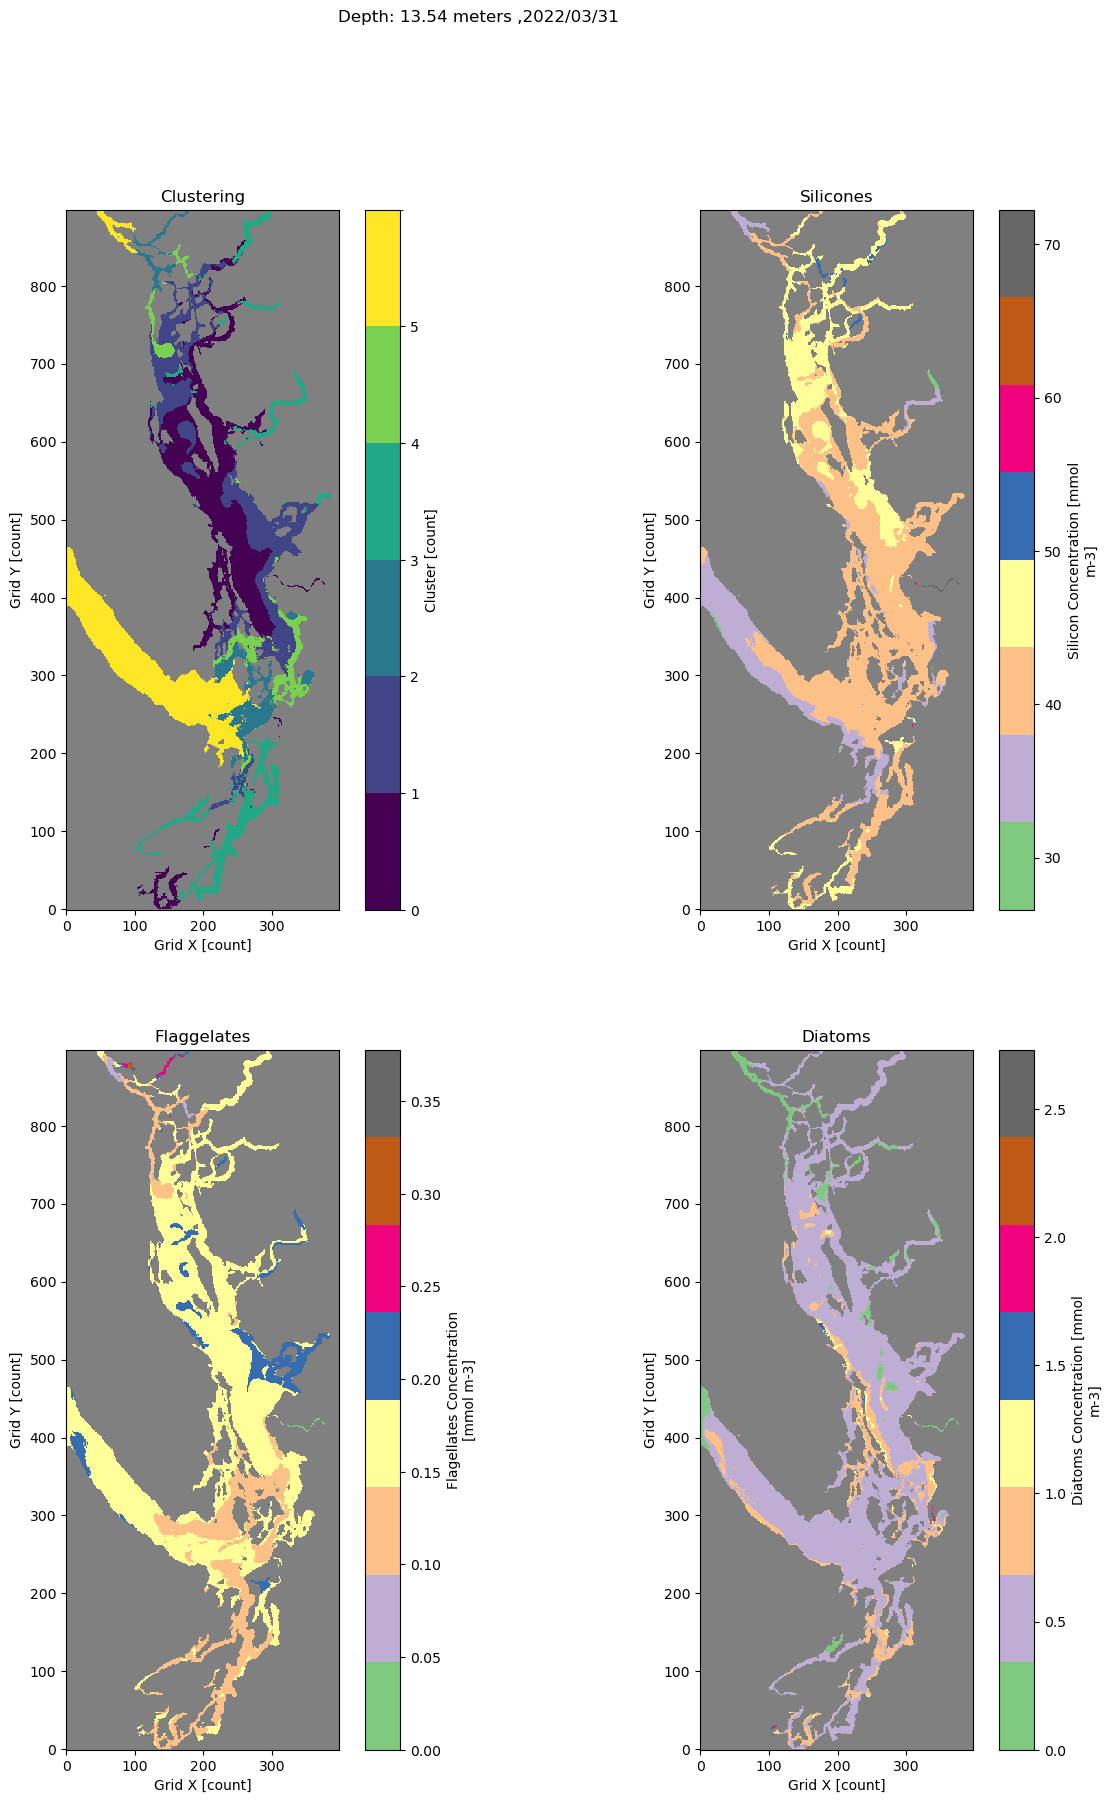

The amount of grid boxes for cluster 0 is 4302 

The minimum temperature for cluster 0 is 6.99 degrees Celsius
The maximum temperature for cluster 0 is 8.66 degrees Celsius
The mean temperature for cluster 0 is 7.93 degrees Celsius 

The minimum salinity for cluster 0 is 29.49 g/kg
The maximum salinity for cluster 0 is 30.03 g/kg
The mean salinity for cluster 0 is 29.75 g/kg 


The amount of grid boxes for cluster 1 is 21912 

The minimum temperature for cluster 1 is 7.6 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.1 degrees Celsius 

The minimum salinity for cluster 1 is 28.66 g/kg
The maximum salinity for cluster 1 is 29.54 g/kg
The mean salinity for cluster 1 is 28.99 g/kg 


The amount of grid boxes for cluster 2 is 18697 

The minimum temperature for cluster 2 is 7.5 degrees Celsius
The maximum temperature for cluster 2 is 10.54 degrees Celsius
The mean temperature for cluster 2 is 8.31 degrees Celsius 

The

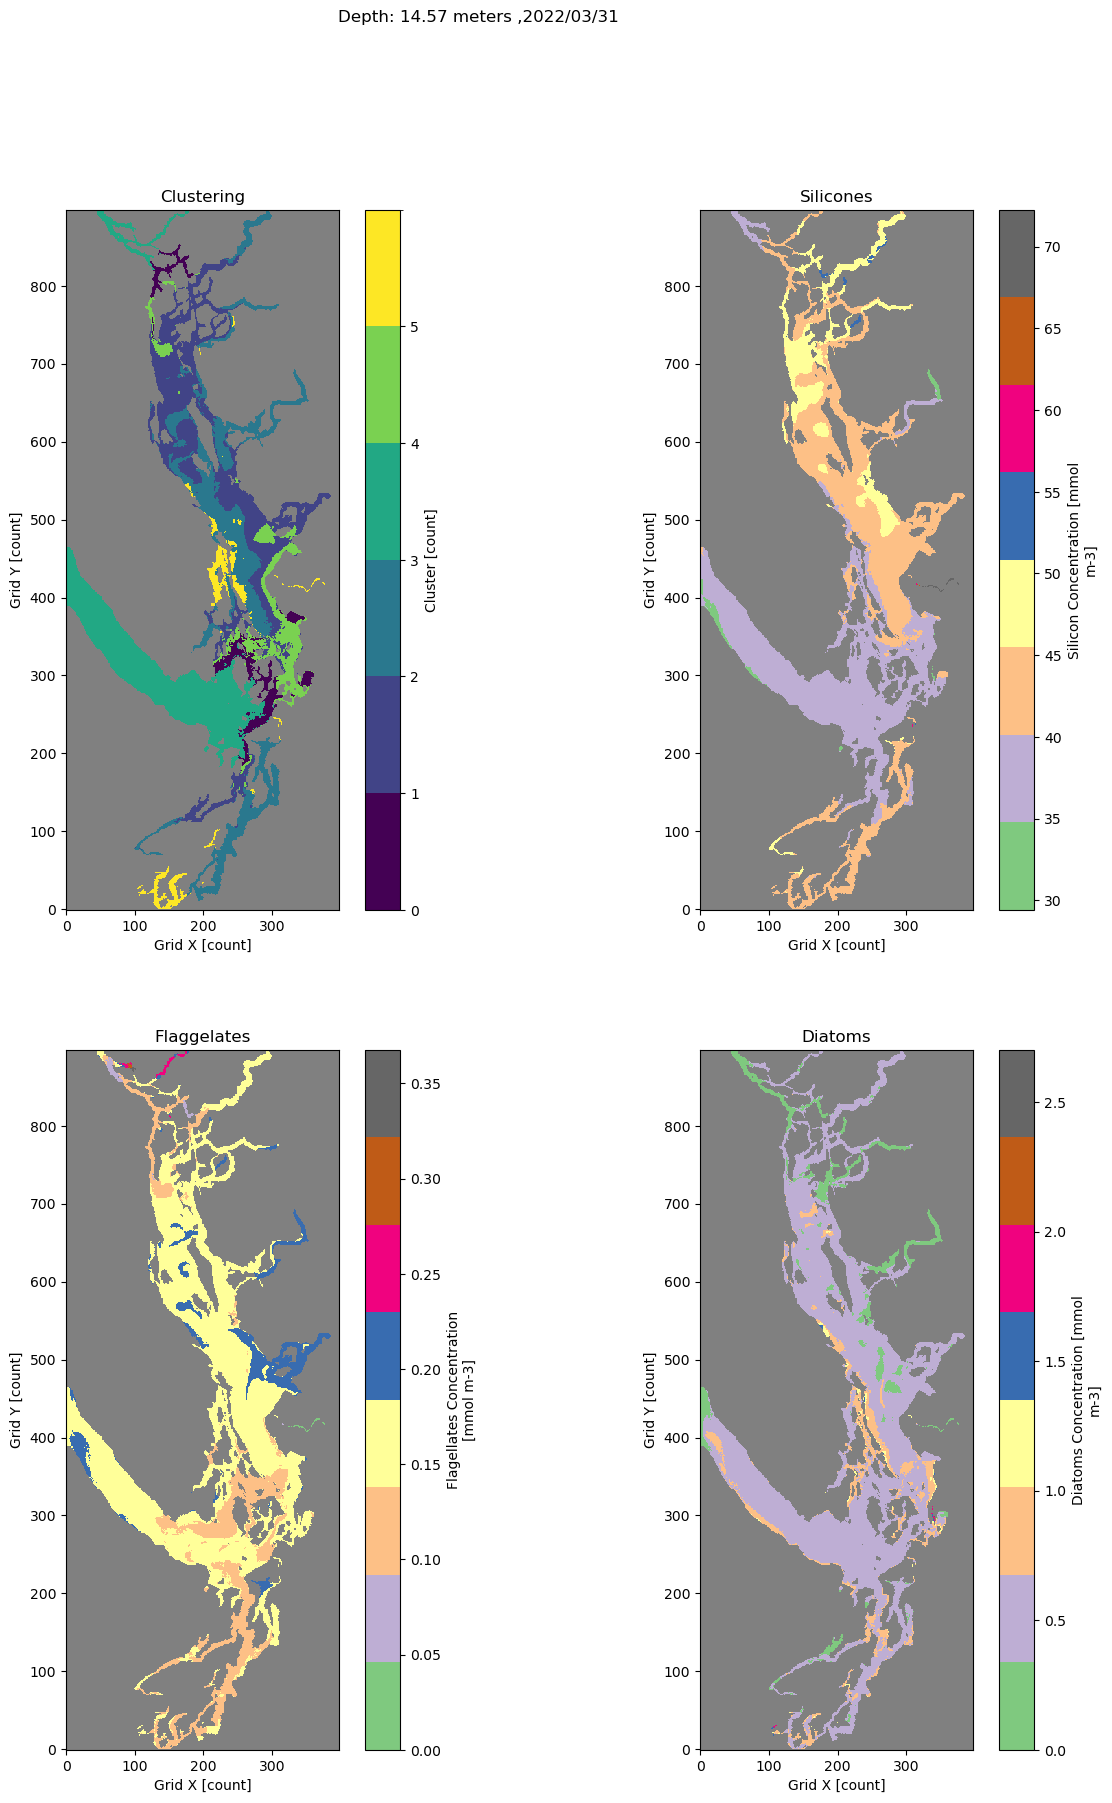

The amount of grid boxes for cluster 0 is 24418 

The minimum temperature for cluster 0 is 6.42 degrees Celsius
The maximum temperature for cluster 0 is 9.15 degrees Celsius
The mean temperature for cluster 0 is 7.98 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.06 g/kg
The mean salinity for cluster 0 is 28.6 g/kg 


The amount of grid boxes for cluster 1 is 5064 

The minimum temperature for cluster 1 is 7.55 degrees Celsius
The maximum temperature for cluster 1 is 8.57 degrees Celsius
The mean temperature for cluster 1 is 7.97 degrees Celsius 

The minimum salinity for cluster 1 is 29.2 g/kg
The maximum salinity for cluster 1 is 29.8 g/kg
The mean salinity for cluster 1 is 29.53 g/kg 


The amount of grid boxes for cluster 2 is 17366 

The minimum temperature for cluster 2 is 7.2 degrees Celsius
The maximum temperature for cluster 2 is 8.26 degrees Celsius
The mean temperature for cluster 2 is 7.81 degrees Celsius 

The mini

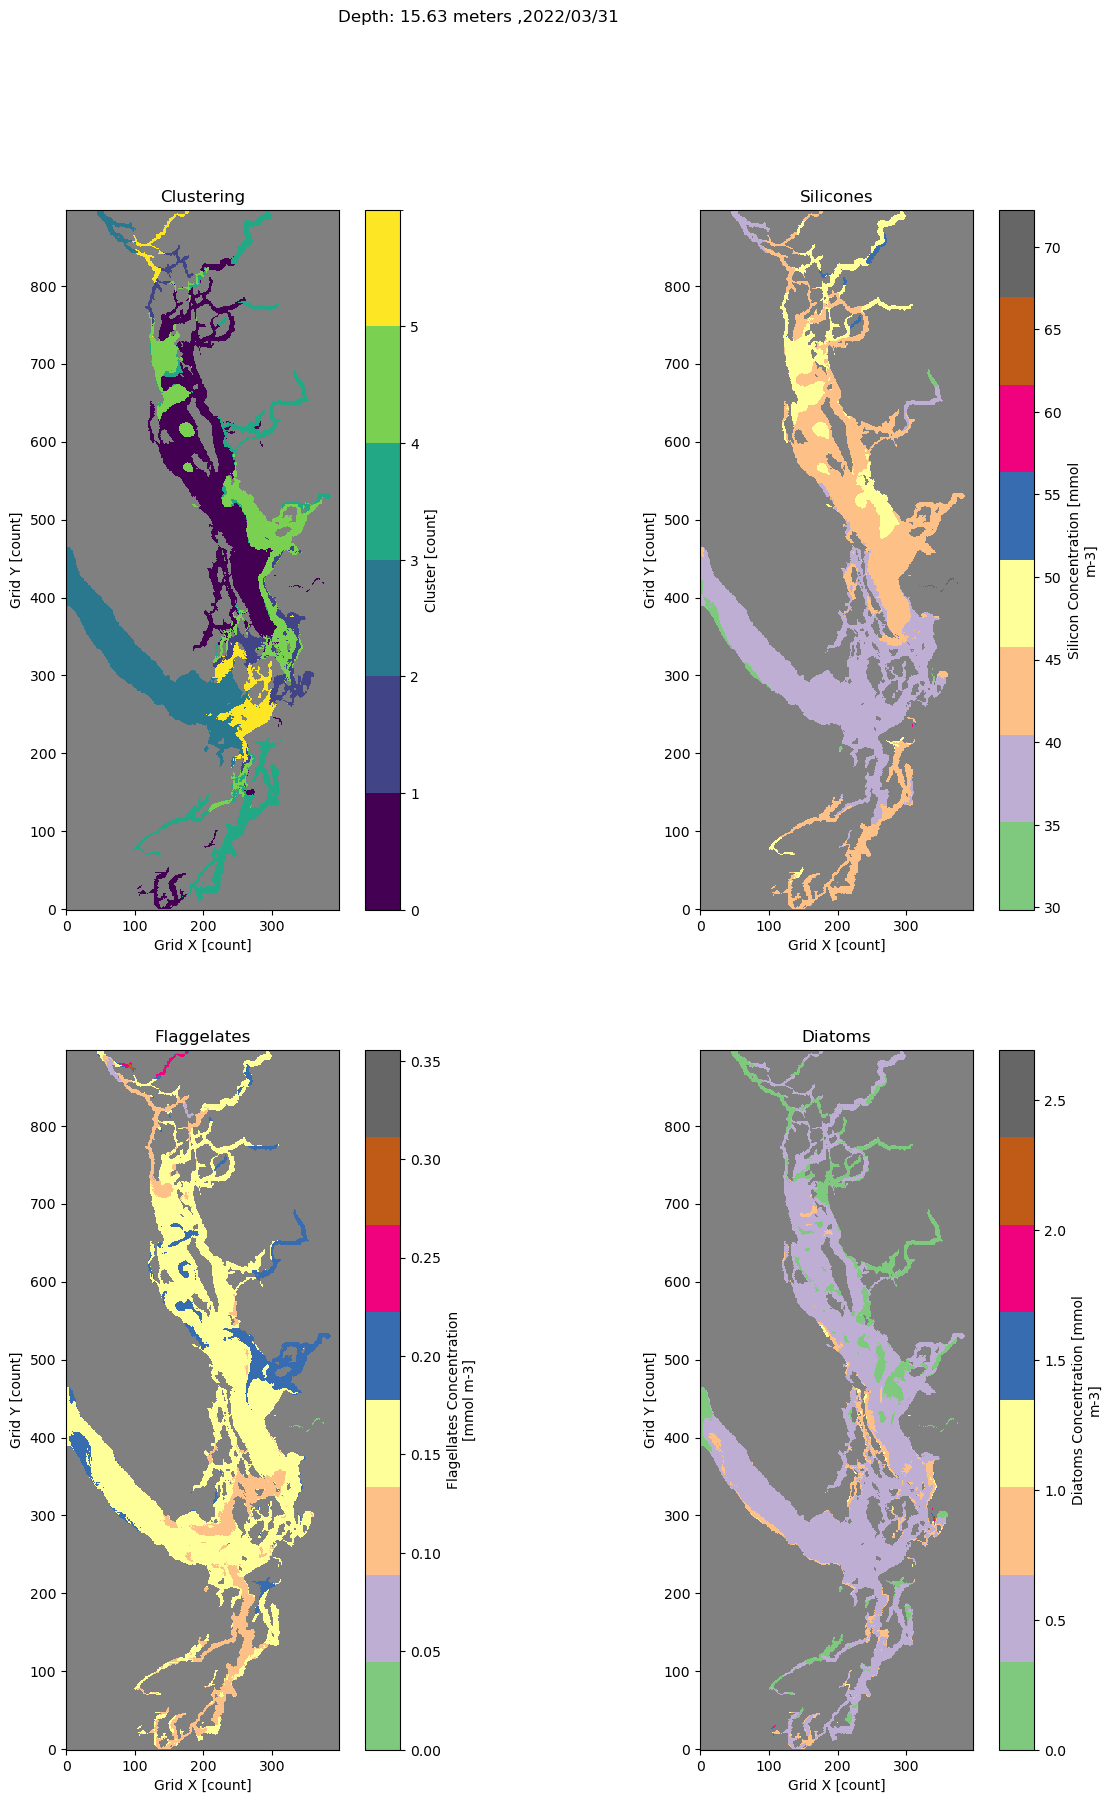

The amount of grid boxes for cluster 0 is 17526 

The minimum temperature for cluster 0 is 7.17 degrees Celsius
The maximum temperature for cluster 0 is 8.22 degrees Celsius
The mean temperature for cluster 0 is 7.8 degrees Celsius 

The minimum salinity for cluster 0 is 30.11 g/kg
The maximum salinity for cluster 0 is 31.83 g/kg
The mean salinity for cluster 0 is 30.9 g/kg 


The amount of grid boxes for cluster 1 is 6520 

The minimum temperature for cluster 1 is 7.56 degrees Celsius
The maximum temperature for cluster 1 is 8.59 degrees Celsius
The mean temperature for cluster 1 is 7.98 degrees Celsius 

The minimum salinity for cluster 1 is 29.19 g/kg
The maximum salinity for cluster 1 is 29.76 g/kg
The mean salinity for cluster 1 is 29.5 g/kg 


The amount of grid boxes for cluster 2 is 20443 

The minimum temperature for cluster 2 is 7.35 degrees Celsius
The maximum temperature for cluster 2 is 8.61 degrees Celsius
The mean temperature for cluster 2 is 7.94 degrees Celsius 

The m

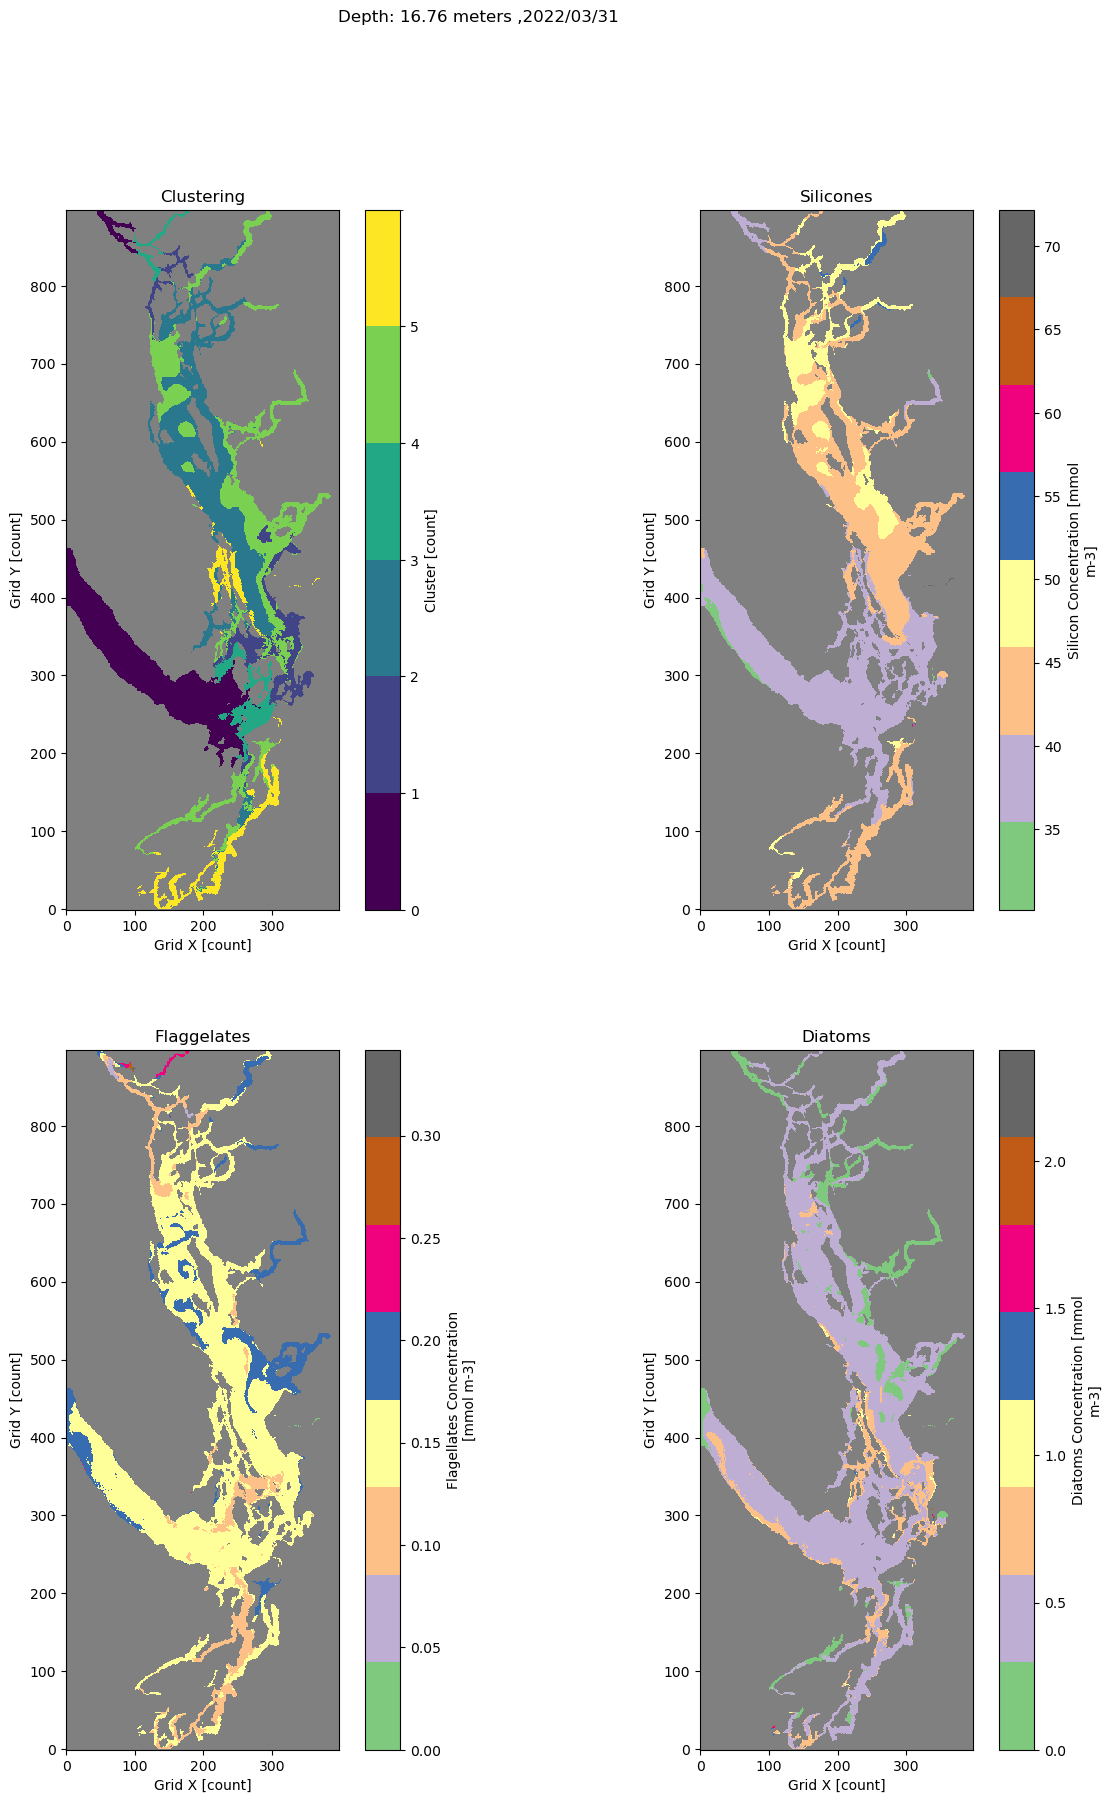

The amount of grid boxes for cluster 0 is 15781 

The minimum temperature for cluster 0 is 7.16 degrees Celsius
The maximum temperature for cluster 0 is 8.22 degrees Celsius
The mean temperature for cluster 0 is 7.78 degrees Celsius 

The minimum salinity for cluster 0 is 30.37 g/kg
The maximum salinity for cluster 0 is 31.89 g/kg
The mean salinity for cluster 0 is 30.98 g/kg 


The amount of grid boxes for cluster 1 is 4817 

The minimum temperature for cluster 1 is 7.57 degrees Celsius
The maximum temperature for cluster 1 is 8.27 degrees Celsius
The mean temperature for cluster 1 is 7.93 degrees Celsius 

The minimum salinity for cluster 1 is 29.24 g/kg
The maximum salinity for cluster 1 is 29.93 g/kg
The mean salinity for cluster 1 is 29.62 g/kg 


The amount of grid boxes for cluster 2 is 24930 

The minimum temperature for cluster 2 is 6.48 degrees Celsius
The maximum temperature for cluster 2 is 9.13 degrees Celsius
The mean temperature for cluster 2 is 7.99 degrees Celsius 

Th

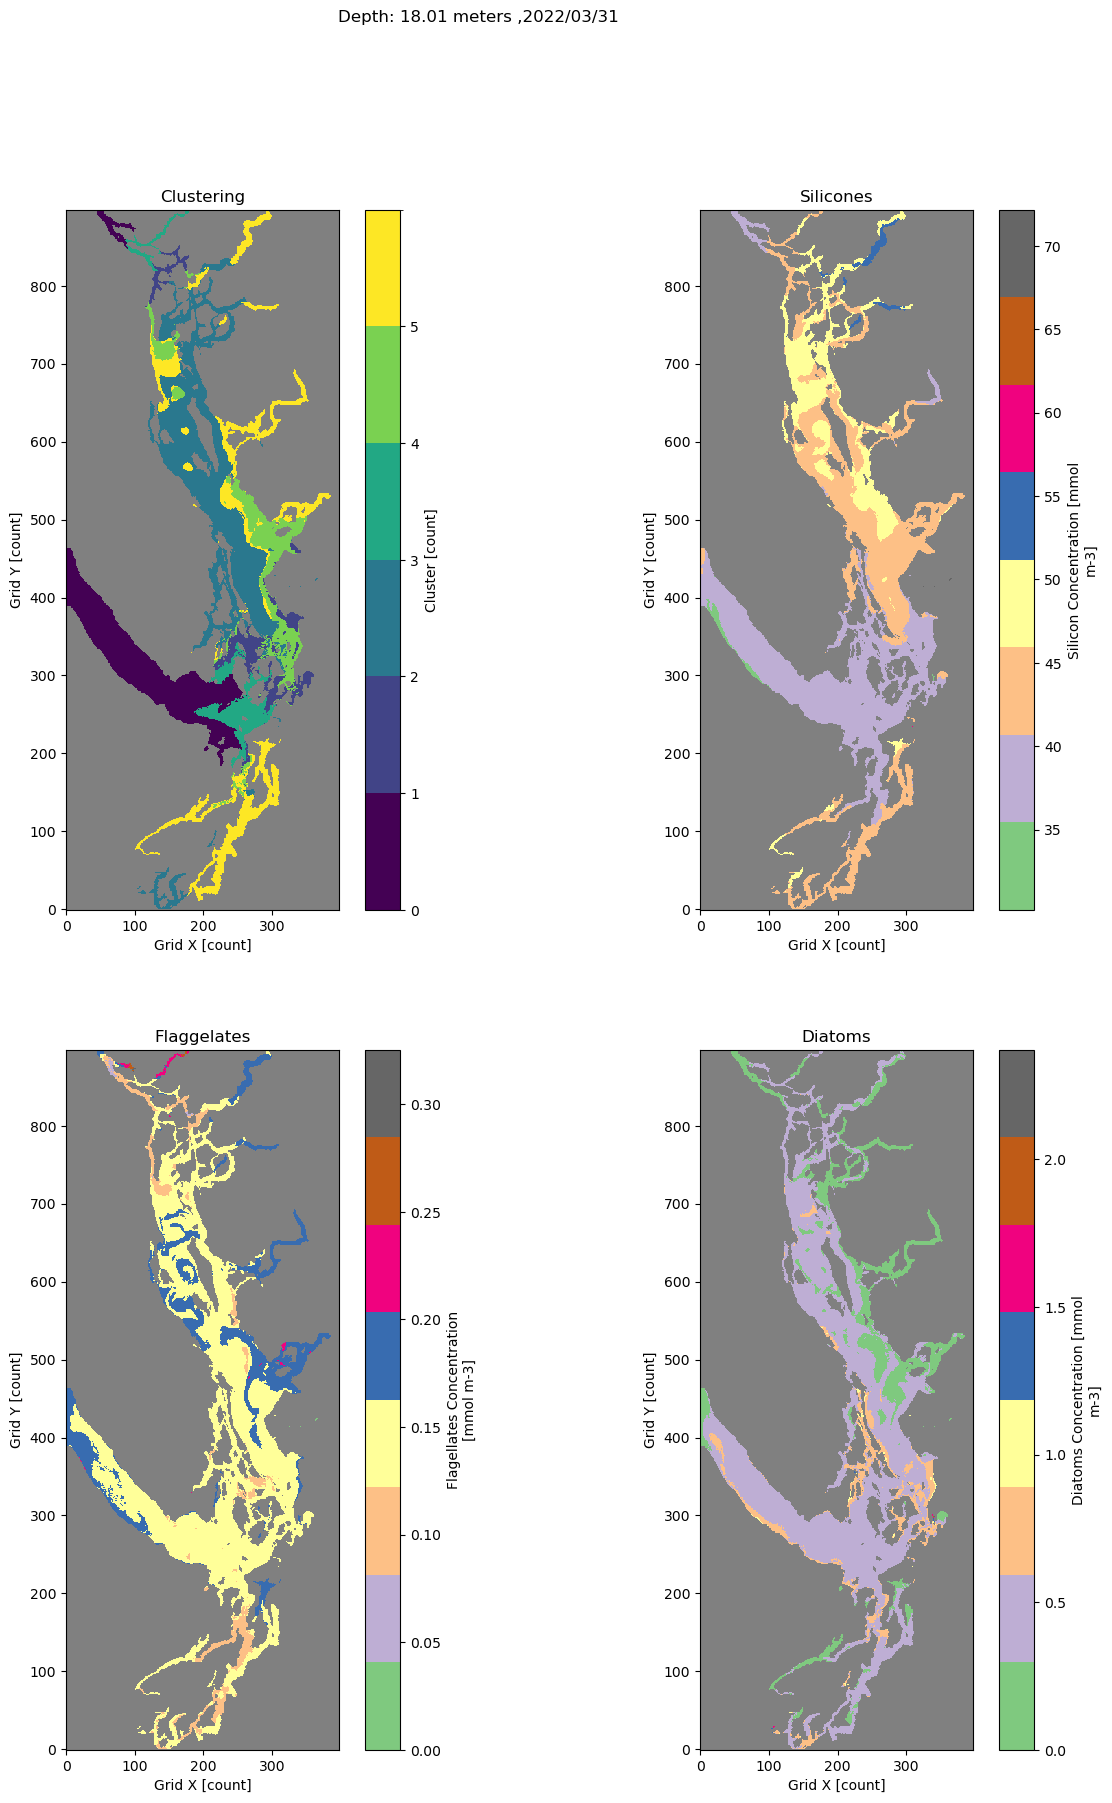

The amount of grid boxes for cluster 0 is 14257 

The minimum temperature for cluster 0 is 8.1 degrees Celsius
The maximum temperature for cluster 0 is 10.33 degrees Celsius
The mean temperature for cluster 0 is 8.68 degrees Celsius 

The minimum salinity for cluster 0 is 28.17 g/kg
The maximum salinity for cluster 0 is 29.76 g/kg
The mean salinity for cluster 0 is 29.16 g/kg 


The amount of grid boxes for cluster 1 is 7972 

The minimum temperature for cluster 1 is 7.92 degrees Celsius
The maximum temperature for cluster 1 is 8.67 degrees Celsius
The mean temperature for cluster 1 is 8.17 degrees Celsius 

The minimum salinity for cluster 1 is 29.27 g/kg
The maximum salinity for cluster 1 is 29.89 g/kg
The mean salinity for cluster 1 is 29.42 g/kg 


The amount of grid boxes for cluster 2 is 5014 

The minimum temperature for cluster 2 is 7.25 degrees Celsius
The maximum temperature for cluster 2 is 8.08 degrees Celsius
The mean temperature for cluster 2 is 7.85 degrees Celsius 

The

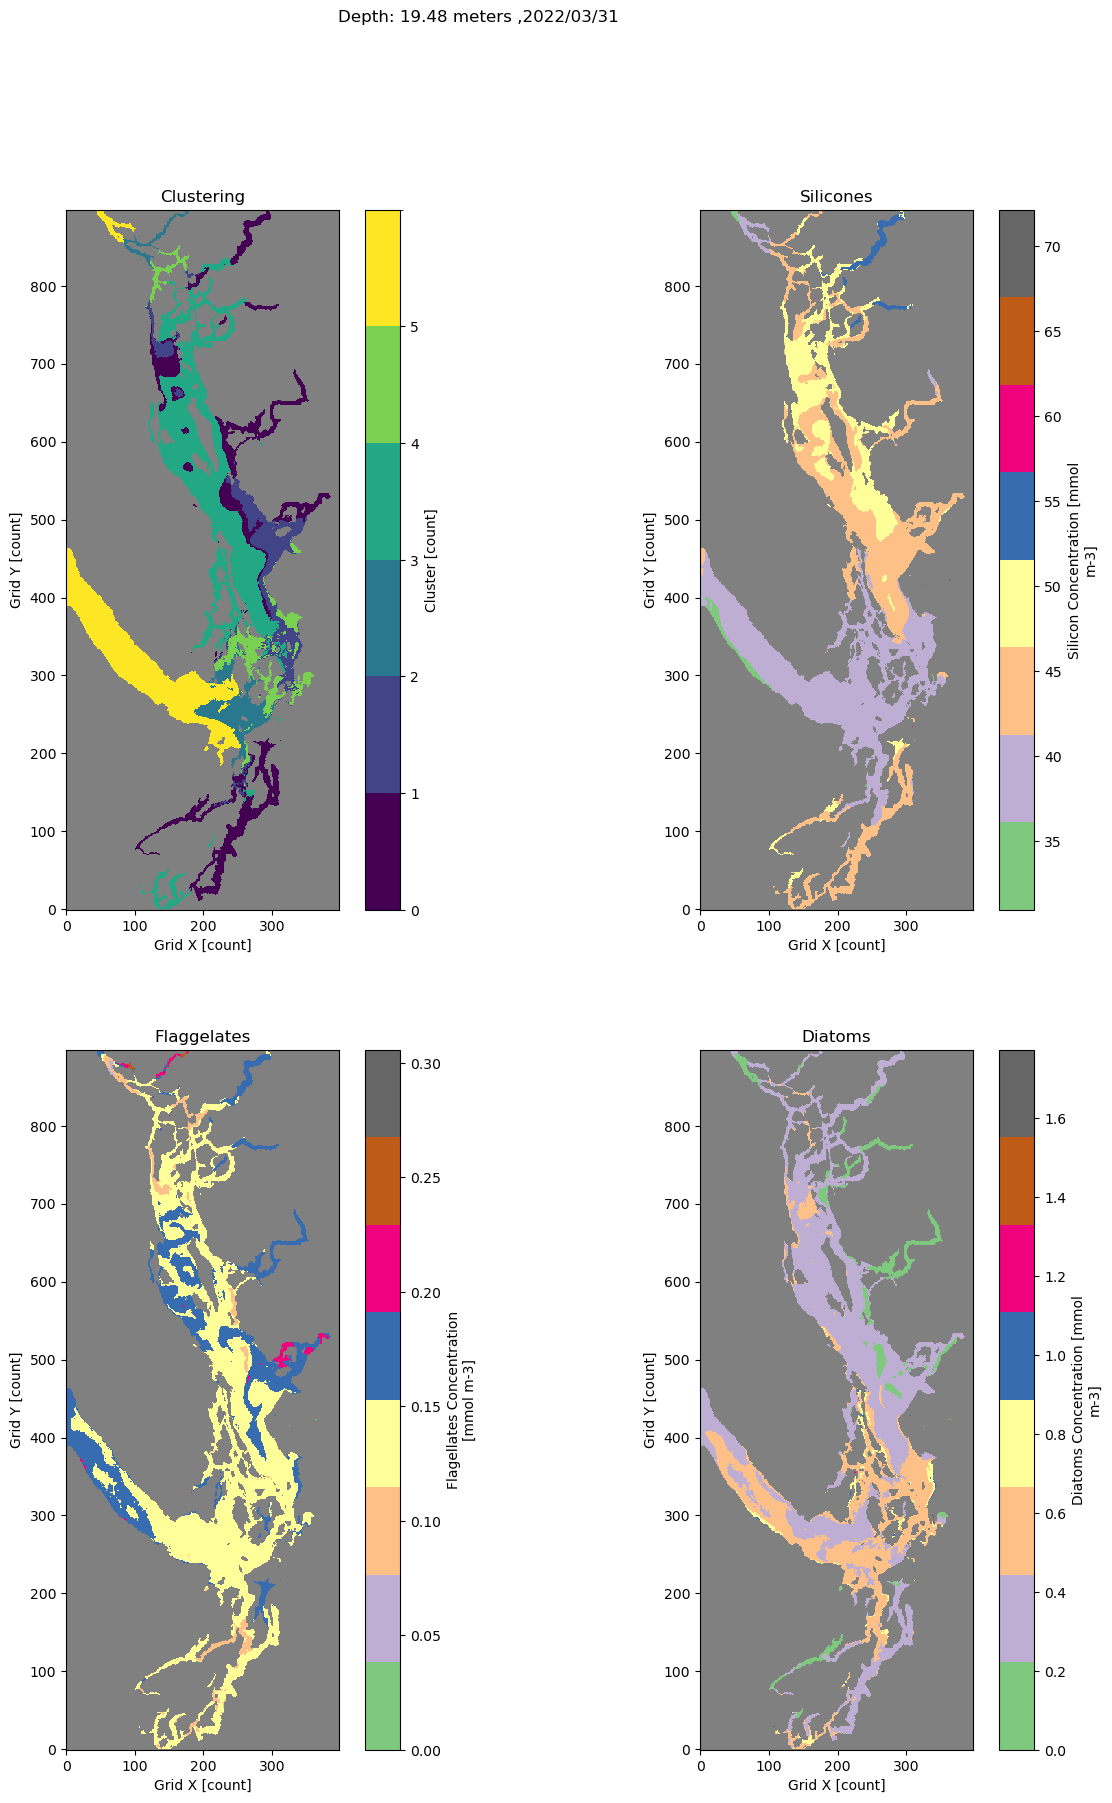

The amount of grid boxes for cluster 0 is 24682 

The minimum temperature for cluster 0 is 7.34 degrees Celsius
The maximum temperature for cluster 0 is 9.04 degrees Celsius
The mean temperature for cluster 0 is 8.04 degrees Celsius 

The minimum salinity for cluster 0 is 23.37 g/kg
The maximum salinity for cluster 0 is 29.28 g/kg
The mean salinity for cluster 0 is 28.91 g/kg 


The amount of grid boxes for cluster 1 is 10261 

The minimum temperature for cluster 1 is 7.59 degrees Celsius
The maximum temperature for cluster 1 is 8.37 degrees Celsius
The mean temperature for cluster 1 is 8.05 degrees Celsius 

The minimum salinity for cluster 1 is 29.19 g/kg
The maximum salinity for cluster 1 is 29.72 g/kg
The mean salinity for cluster 1 is 29.44 g/kg 


The amount of grid boxes for cluster 2 is 4794 

The minimum temperature for cluster 2 is 7.28 degrees Celsius
The maximum temperature for cluster 2 is 8.14 degrees Celsius
The mean temperature for cluster 2 is 7.84 degrees Celsius 

Th

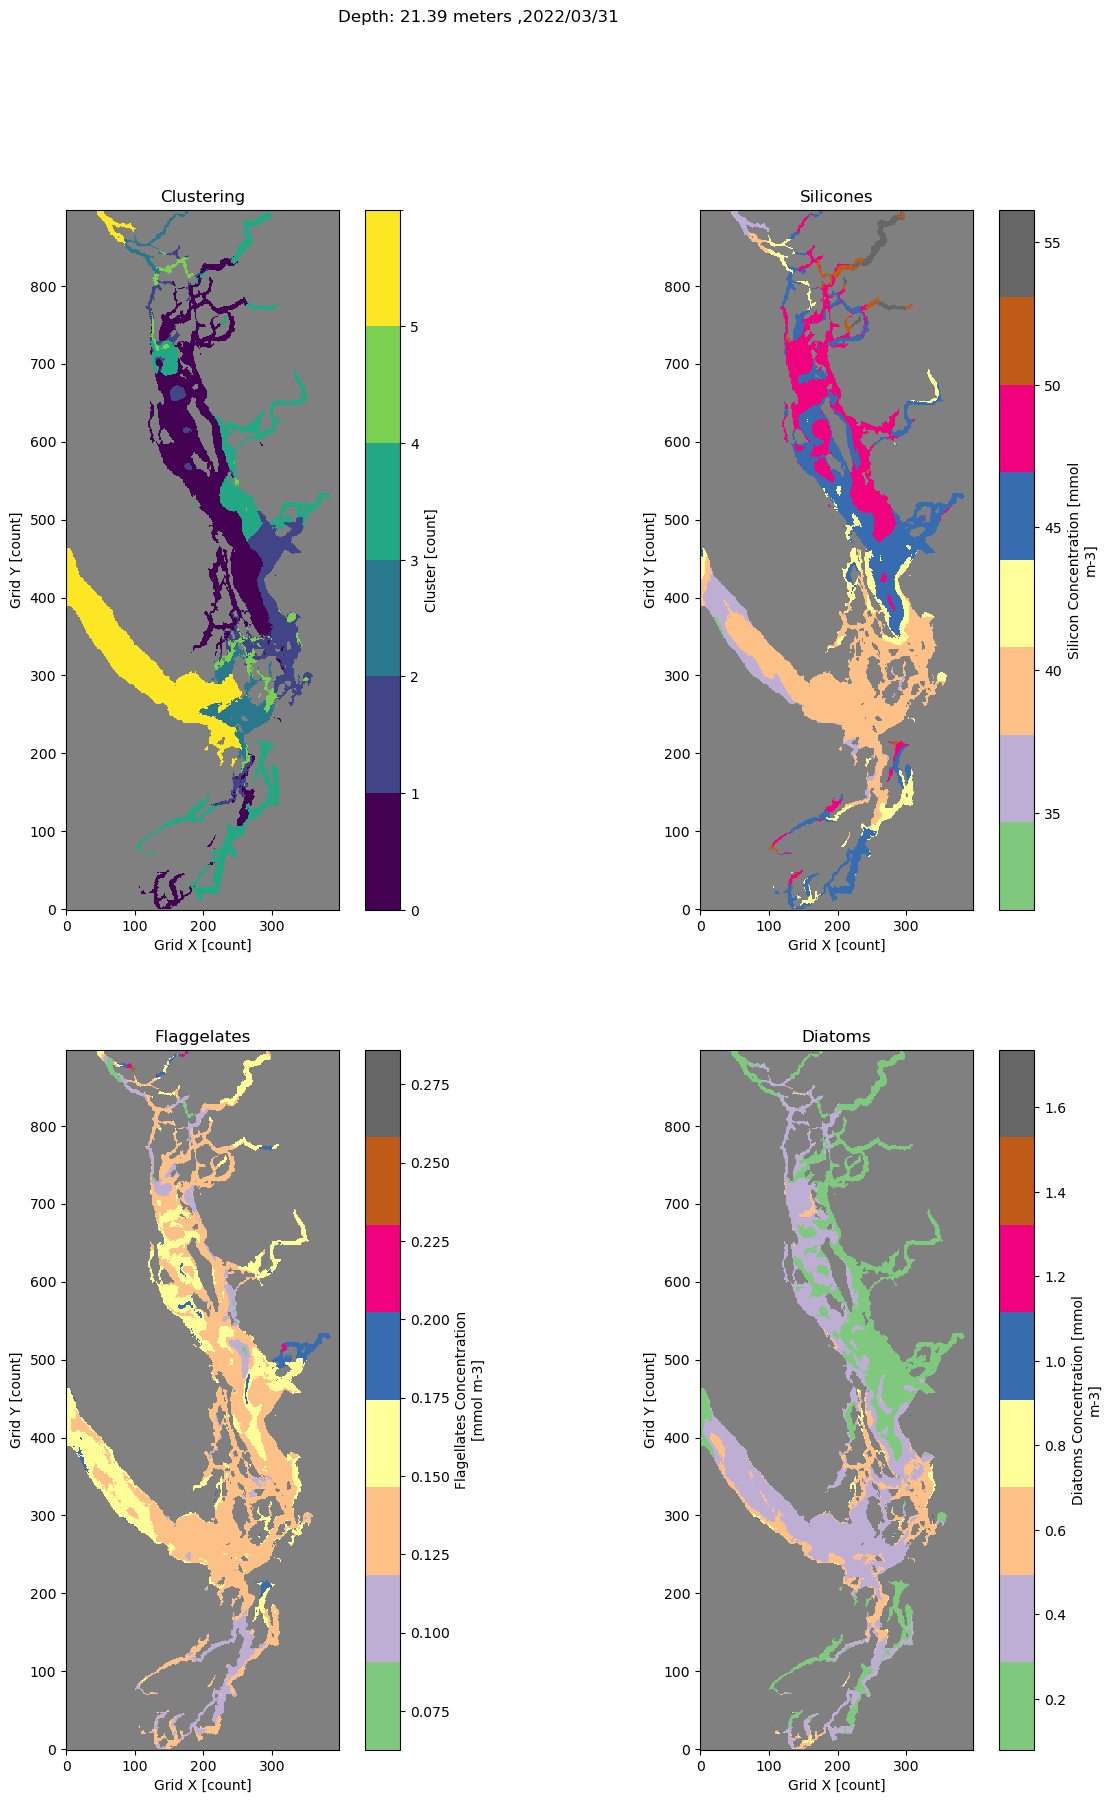

The amount of grid boxes for cluster 0 is 14854 

The minimum temperature for cluster 0 is 7.13 degrees Celsius
The maximum temperature for cluster 0 is 8.13 degrees Celsius
The mean temperature for cluster 0 is 7.73 degrees Celsius 

The minimum salinity for cluster 0 is 30.49 g/kg
The maximum salinity for cluster 0 is 32.22 g/kg
The mean salinity for cluster 0 is 31.11 g/kg 


The amount of grid boxes for cluster 1 is 10255 

The minimum temperature for cluster 1 is 7.62 degrees Celsius
The maximum temperature for cluster 1 is 8.16 degrees Celsius
The mean temperature for cluster 1 is 7.98 degrees Celsius 

The minimum salinity for cluster 1 is 29.27 g/kg
The maximum salinity for cluster 1 is 30.03 g/kg
The mean salinity for cluster 1 is 29.57 g/kg 


The amount of grid boxes for cluster 2 is 23091 

The minimum temperature for cluster 2 is 7.34 degrees Celsius
The maximum temperature for cluster 2 is 8.81 degrees Celsius
The mean temperature for cluster 2 is 8.05 degrees Celsius 

T

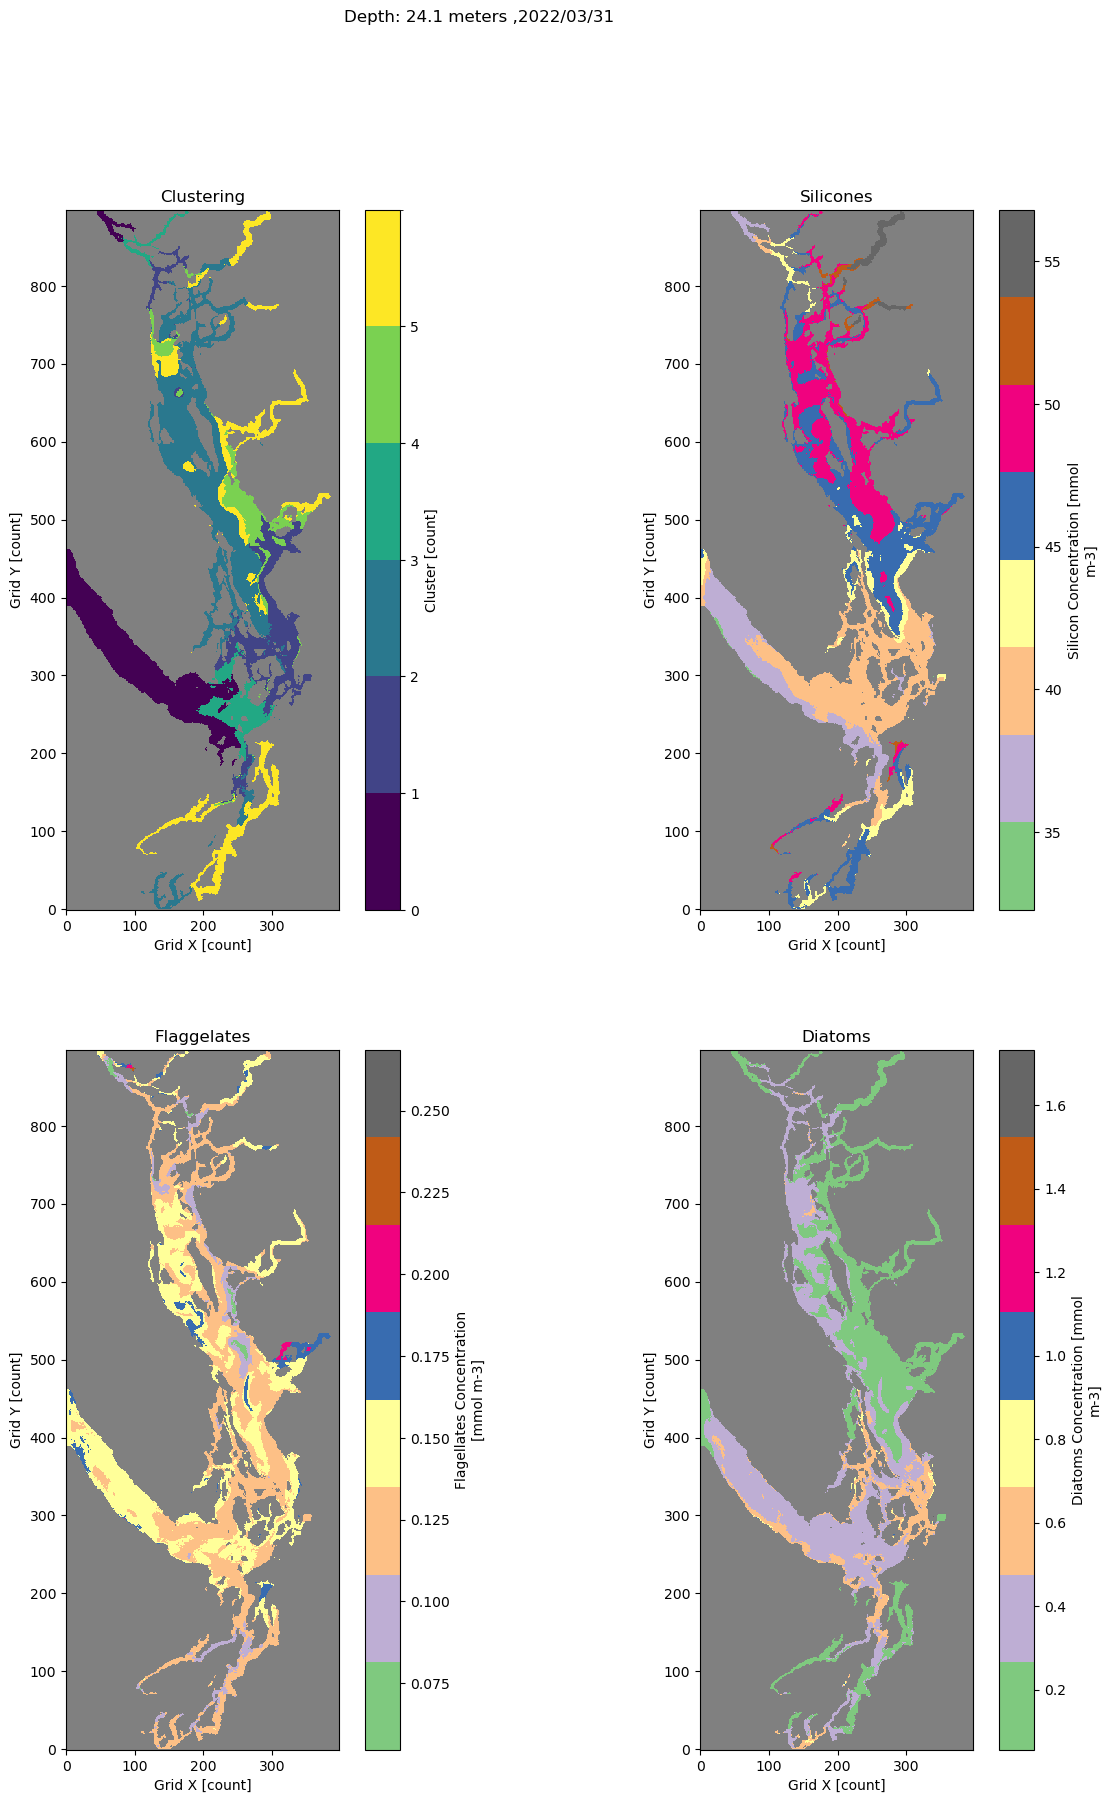

The amount of grid boxes for cluster 0 is 12821 

The minimum temperature for cluster 0 is 8.09 degrees Celsius
The maximum temperature for cluster 0 is 10.21 degrees Celsius
The mean temperature for cluster 0 is 8.56 degrees Celsius 

The minimum salinity for cluster 0 is 26.61 g/kg
The maximum salinity for cluster 0 is 29.78 g/kg
The mean salinity for cluster 0 is 29.16 g/kg 


The amount of grid boxes for cluster 1 is 12200 

The minimum temperature for cluster 1 is 7.84 degrees Celsius
The maximum temperature for cluster 1 is 9.92 degrees Celsius
The mean temperature for cluster 1 is 8.48 degrees Celsius 

The minimum salinity for cluster 1 is 29.48 g/kg
The maximum salinity for cluster 1 is 30.25 g/kg
The mean salinity for cluster 1 is 29.67 g/kg 


The amount of grid boxes for cluster 2 is 4286 

The minimum temperature for cluster 2 is 7.56 degrees Celsius
The maximum temperature for cluster 2 is 8.01 degrees Celsius
The mean temperature for cluster 2 is 7.8 degrees Celsius 

Th

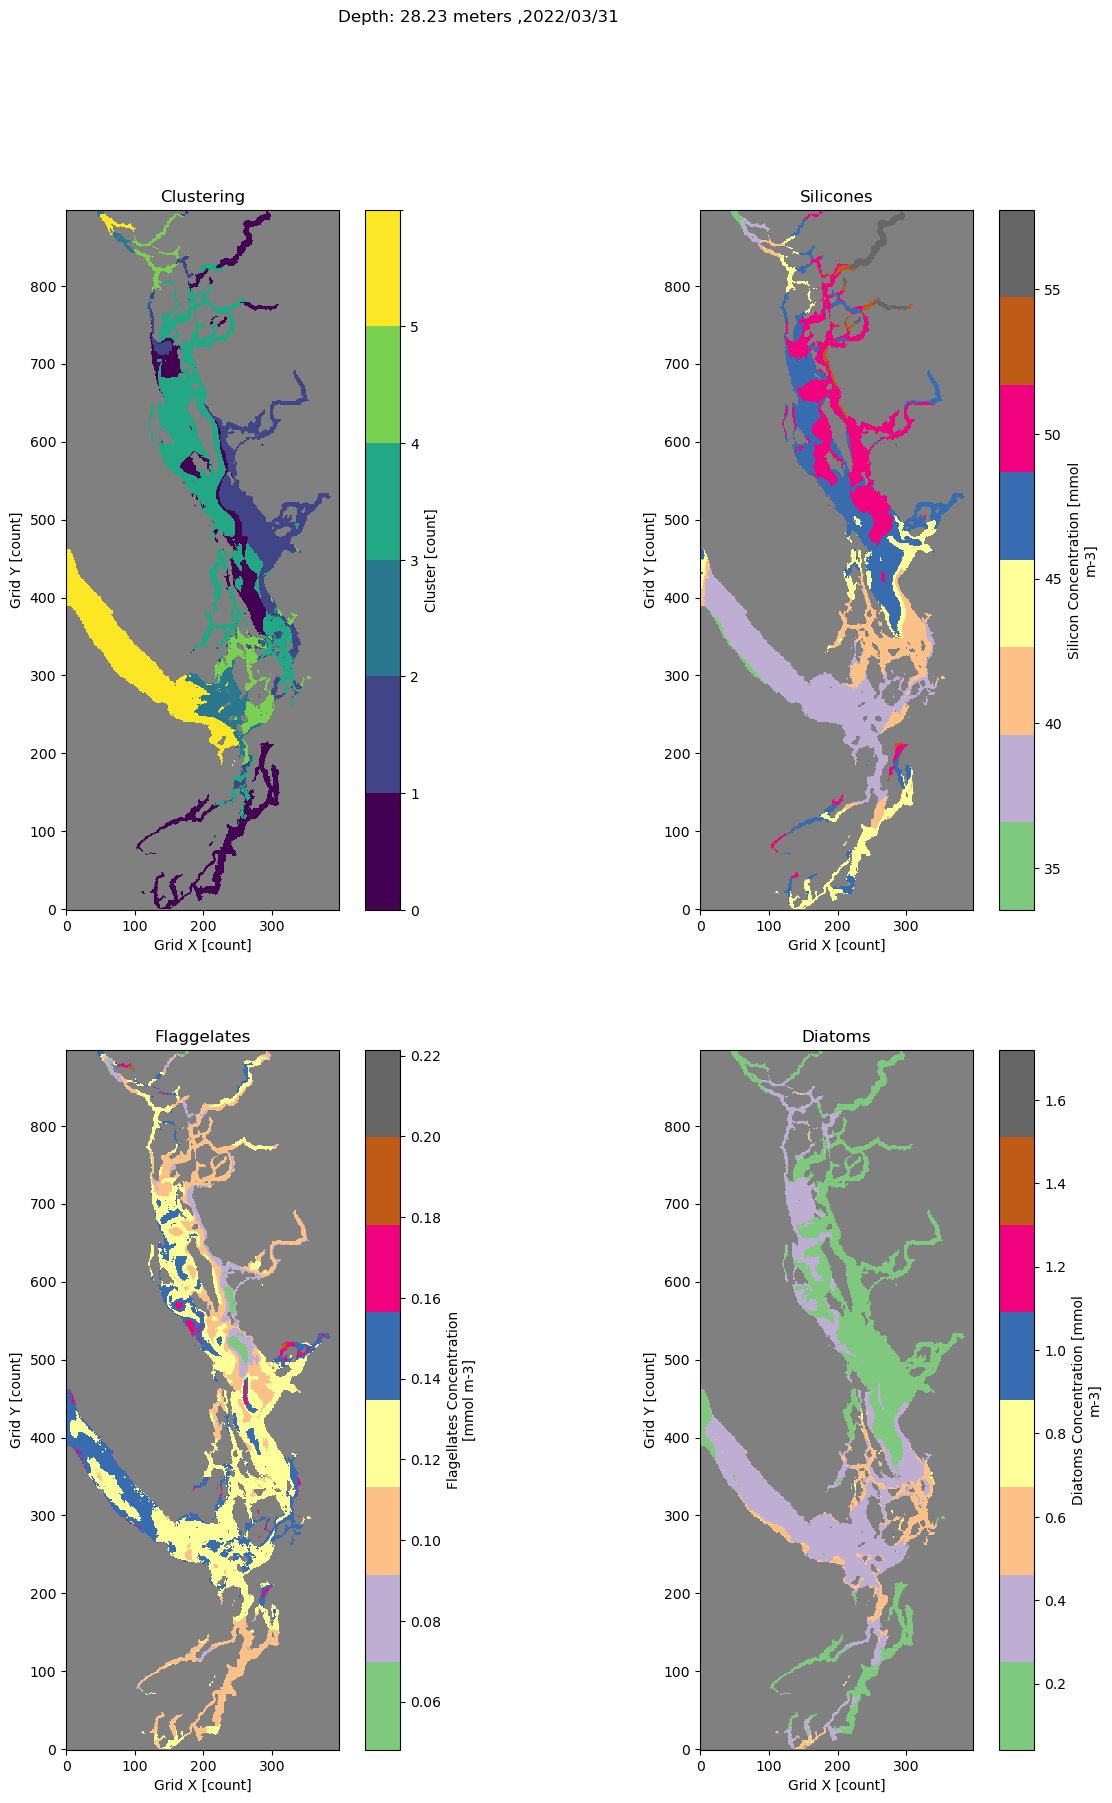

The amount of grid boxes for cluster 0 is 4453 

The minimum temperature for cluster 0 is 7.32 degrees Celsius
The maximum temperature for cluster 0 is 7.99 degrees Celsius
The mean temperature for cluster 0 is 7.77 degrees Celsius 

The minimum salinity for cluster 0 is 29.99 g/kg
The maximum salinity for cluster 0 is 30.79 g/kg
The mean salinity for cluster 0 is 30.5 g/kg 


The amount of grid boxes for cluster 1 is 10117 

The minimum temperature for cluster 1 is 7.57 degrees Celsius
The maximum temperature for cluster 1 is 8.37 degrees Celsius
The mean temperature for cluster 1 is 7.99 degrees Celsius 

The minimum salinity for cluster 1 is 29.38 g/kg
The maximum salinity for cluster 1 is 30.01 g/kg
The mean salinity for cluster 1 is 29.69 g/kg 


The amount of grid boxes for cluster 2 is 22550 

The minimum temperature for cluster 2 is 7.63 degrees Celsius
The maximum temperature for cluster 2 is 8.78 degrees Celsius
The mean temperature for cluster 2 is 8.2 degrees Celsius 

The 

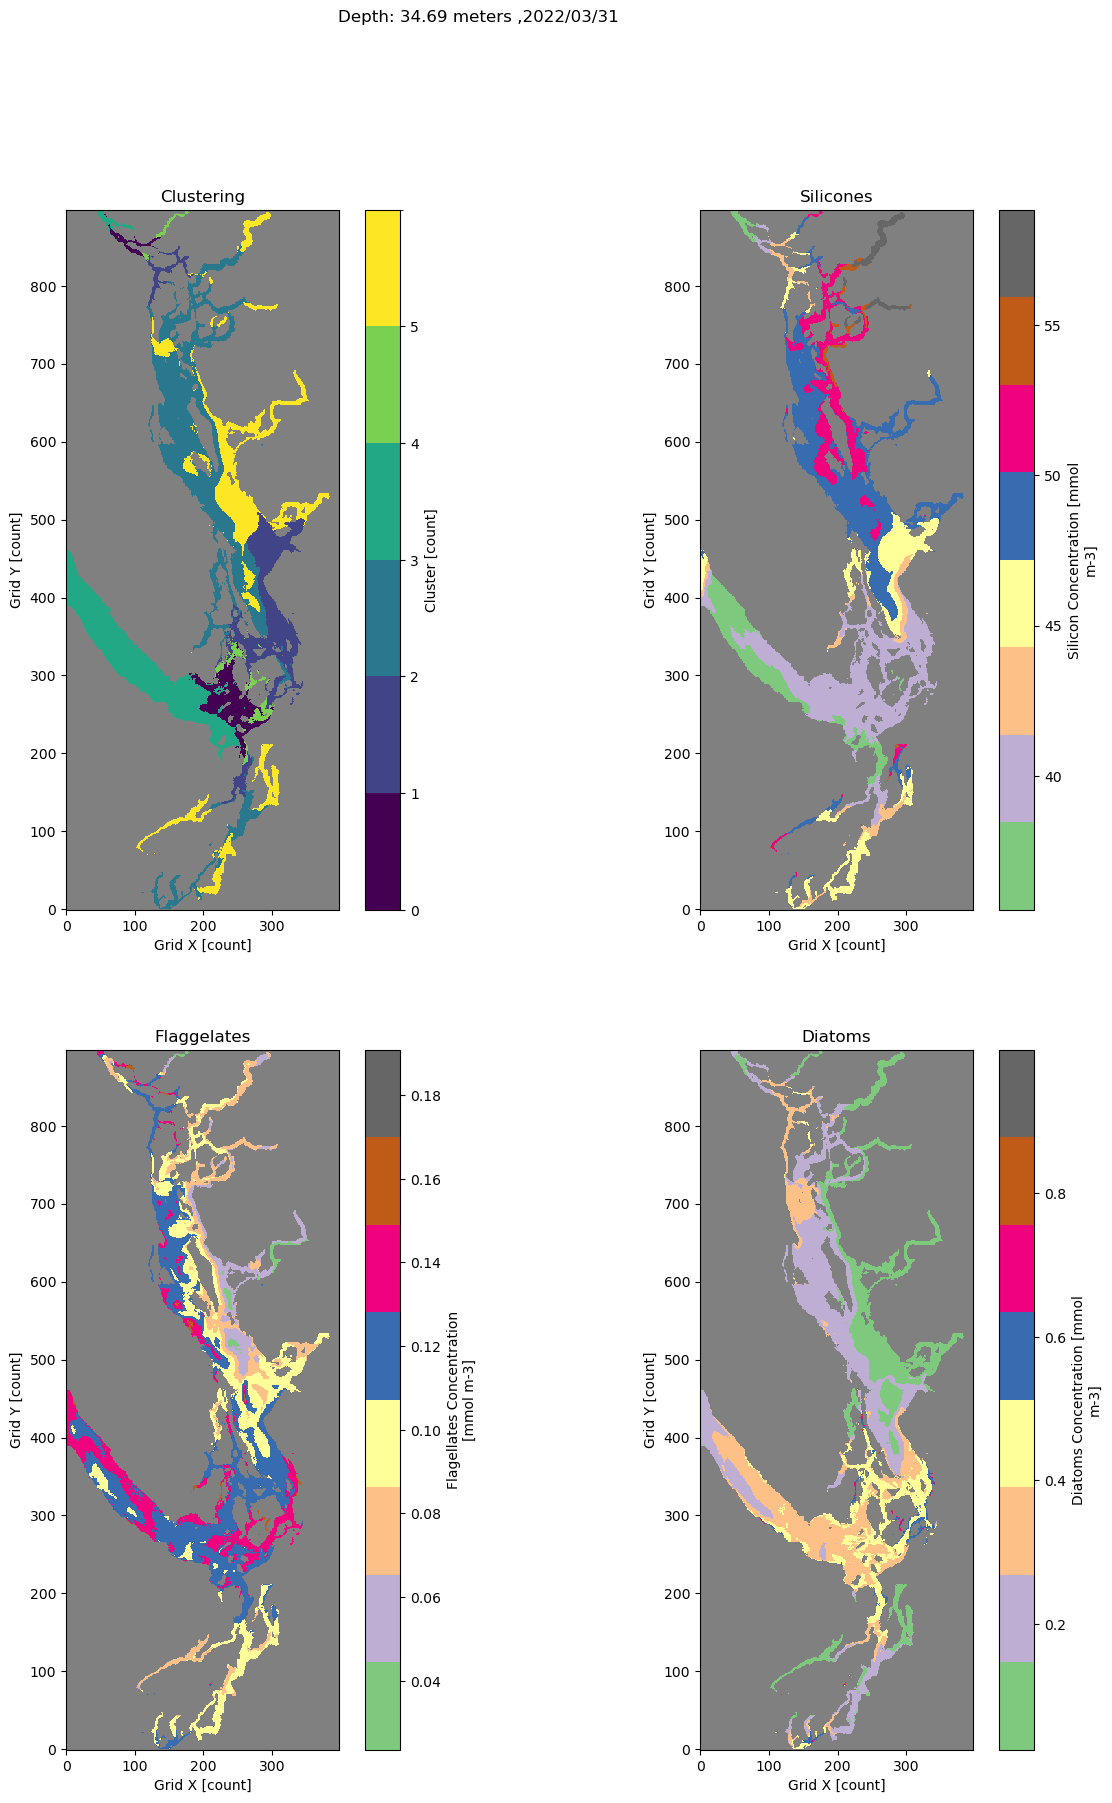

The amount of grid boxes for cluster 0 is 19072 

The minimum temperature for cluster 0 is 8.29 degrees Celsius
The maximum temperature for cluster 0 is 10.31 degrees Celsius
The mean temperature for cluster 0 is 8.71 degrees Celsius 

The minimum salinity for cluster 0 is 29.33 g/kg
The maximum salinity for cluster 0 is 30.38 g/kg
The mean salinity for cluster 0 is 29.76 g/kg 


The amount of grid boxes for cluster 1 is 1383 

The minimum temperature for cluster 1 is 7.95 degrees Celsius
The maximum temperature for cluster 1 is 8.99 degrees Celsius
The mean temperature for cluster 1 is 8.16 degrees Celsius 

The minimum salinity for cluster 1 is 29.84 g/kg
The maximum salinity for cluster 1 is 30.37 g/kg
The mean salinity for cluster 1 is 29.94 g/kg 


The amount of grid boxes for cluster 2 is 3925 

The minimum temperature for cluster 2 is 7.13 degrees Celsius
The maximum temperature for cluster 2 is 7.88 degrees Celsius
The mean temperature for cluster 2 is 7.71 degrees Celsius 

Th

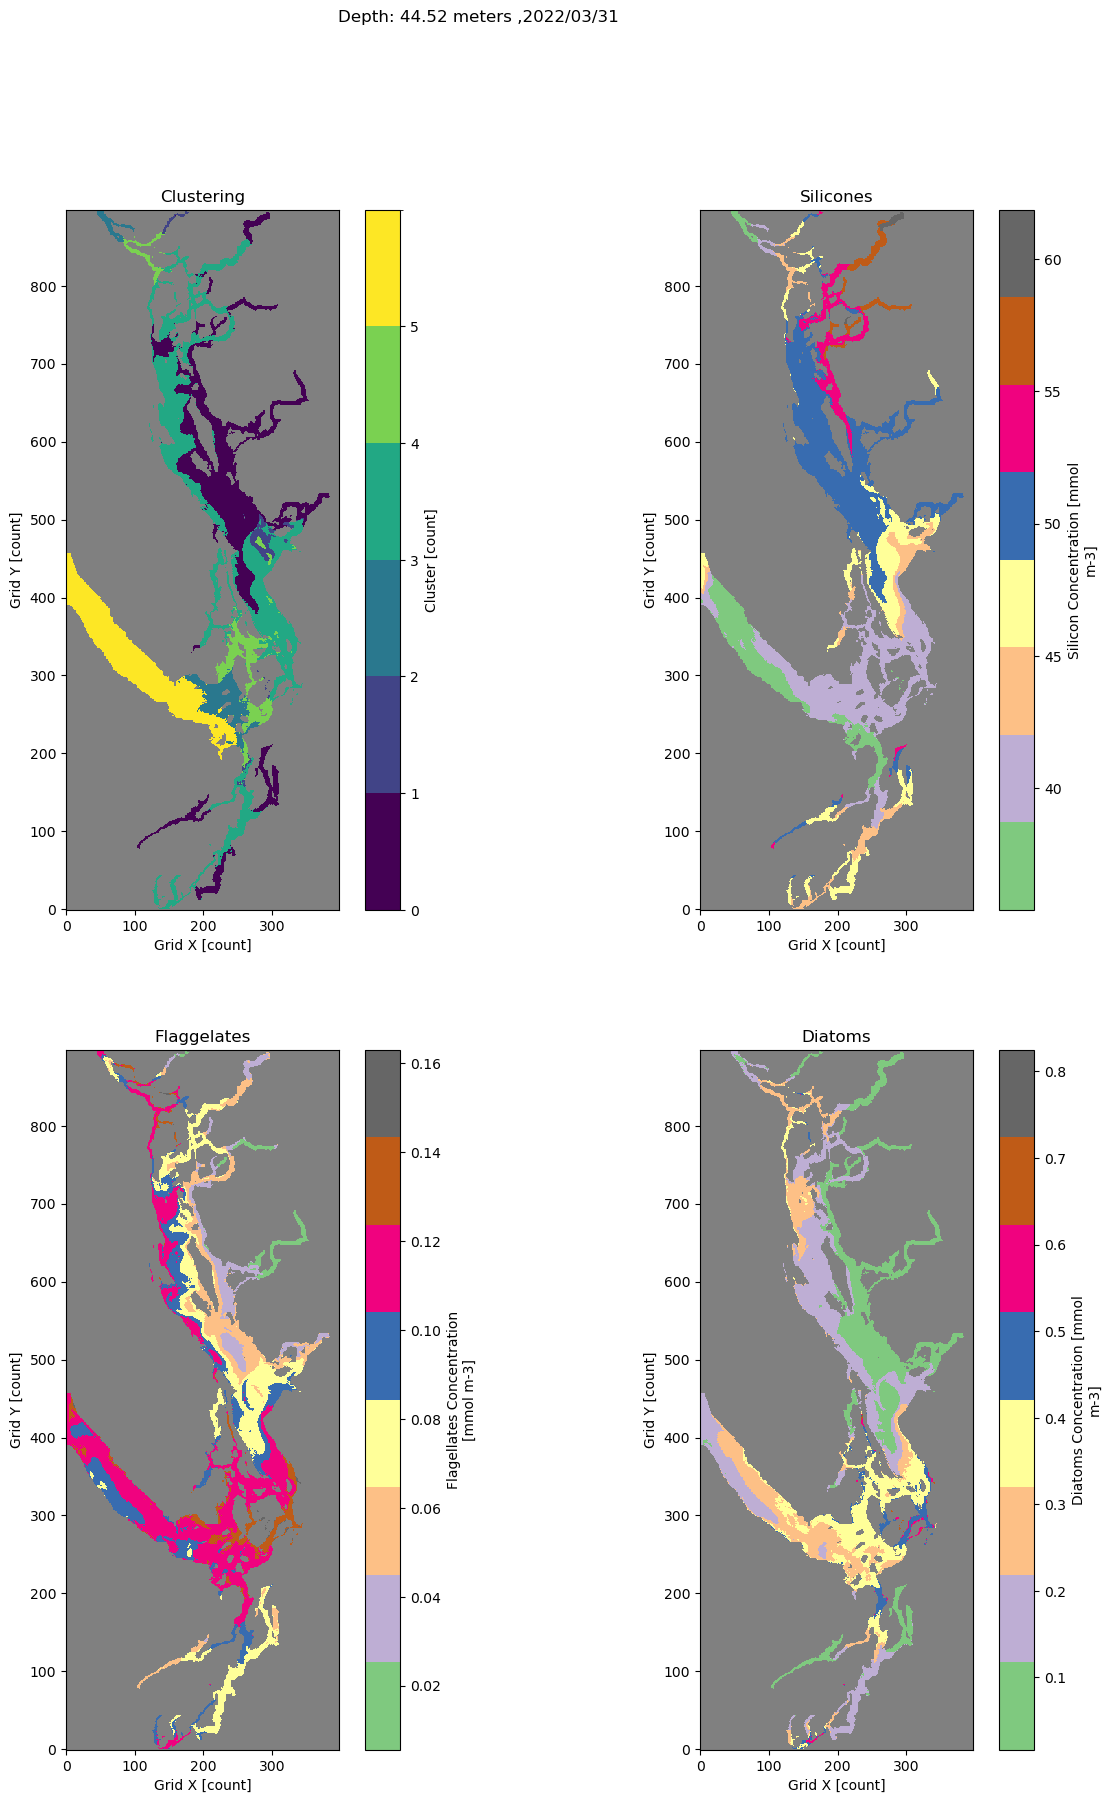

The amount of grid boxes for cluster 0 is 14090 

The minimum temperature for cluster 0 is 7.62 degrees Celsius
The maximum temperature for cluster 0 is 8.67 degrees Celsius
The mean temperature for cluster 0 is 8.34 degrees Celsius 

The minimum salinity for cluster 0 is 27.44 g/kg
The maximum salinity for cluster 0 is 29.97 g/kg
The mean salinity for cluster 0 is 29.57 g/kg 


The amount of grid boxes for cluster 1 is 11313 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 8.42 degrees Celsius
The mean temperature for cluster 1 is 7.96 degrees Celsius 

The minimum salinity for cluster 1 is 29.48 g/kg
The maximum salinity for cluster 1 is 30.31 g/kg
The mean salinity for cluster 1 is 29.92 g/kg 


The amount of grid boxes for cluster 2 is 4298 

The minimum temperature for cluster 2 is 7.15 degrees Celsius
The maximum temperature for cluster 2 is 7.87 degrees Celsius
The mean temperature for cluster 2 is 7.68 degrees Celsius 

Th

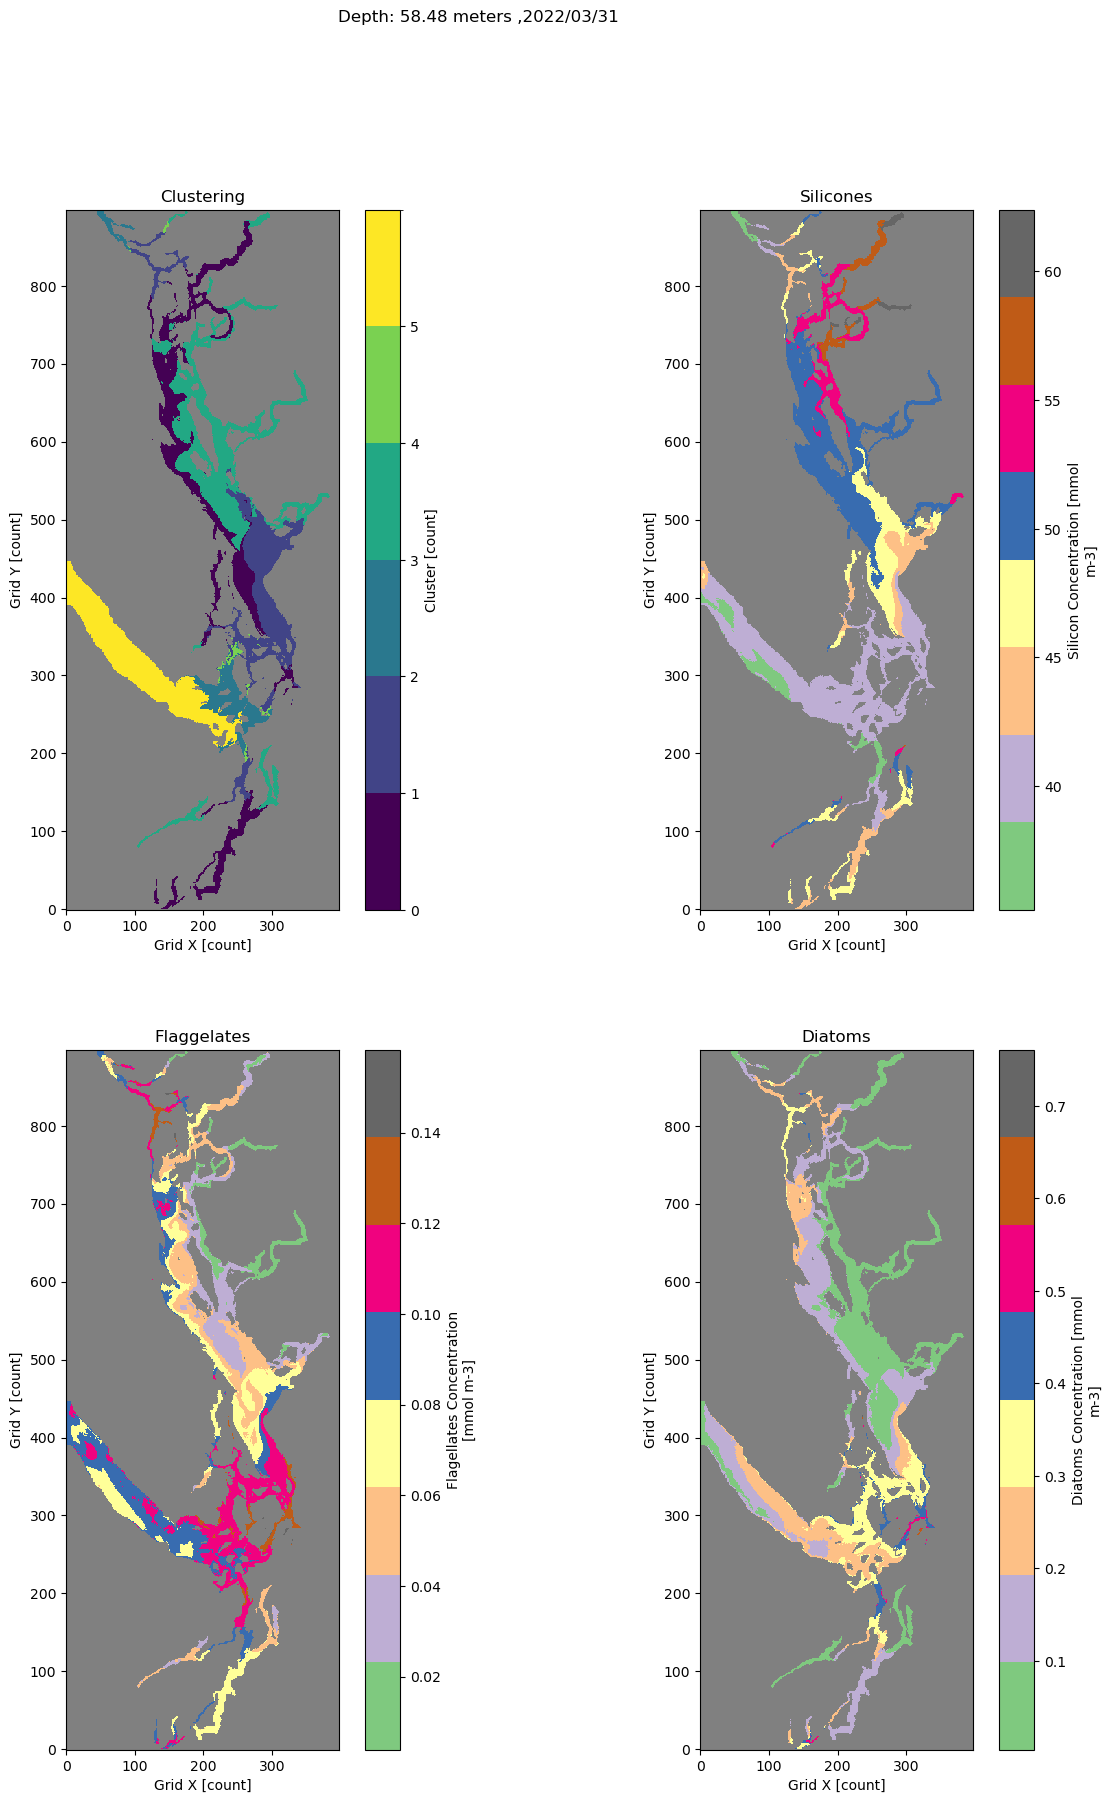

The amount of grid boxes for cluster 0 is 9922 

The minimum temperature for cluster 0 is 7.2 degrees Celsius
The maximum temperature for cluster 0 is 7.54 degrees Celsius
The mean temperature for cluster 0 is 7.34 degrees Celsius 

The minimum salinity for cluster 0 is 31.82 g/kg
The maximum salinity for cluster 0 is 33.38 g/kg
The mean salinity for cluster 0 is 32.67 g/kg 


The amount of grid boxes for cluster 1 is 1048 

The minimum temperature for cluster 1 is 7.59 degrees Celsius
The maximum temperature for cluster 1 is 7.84 degrees Celsius
The mean temperature for cluster 1 is 7.69 degrees Celsius 

The minimum salinity for cluster 1 is 30.62 g/kg
The maximum salinity for cluster 1 is 31.0 g/kg
The mean salinity for cluster 1 is 30.83 g/kg 


The amount of grid boxes for cluster 2 is 18189 

The minimum temperature for cluster 2 is 8.39 degrees Celsius
The maximum temperature for cluster 2 is 10.45 degrees Celsius
The mean temperature for cluster 2 is 8.83 degrees Celsius 

The 

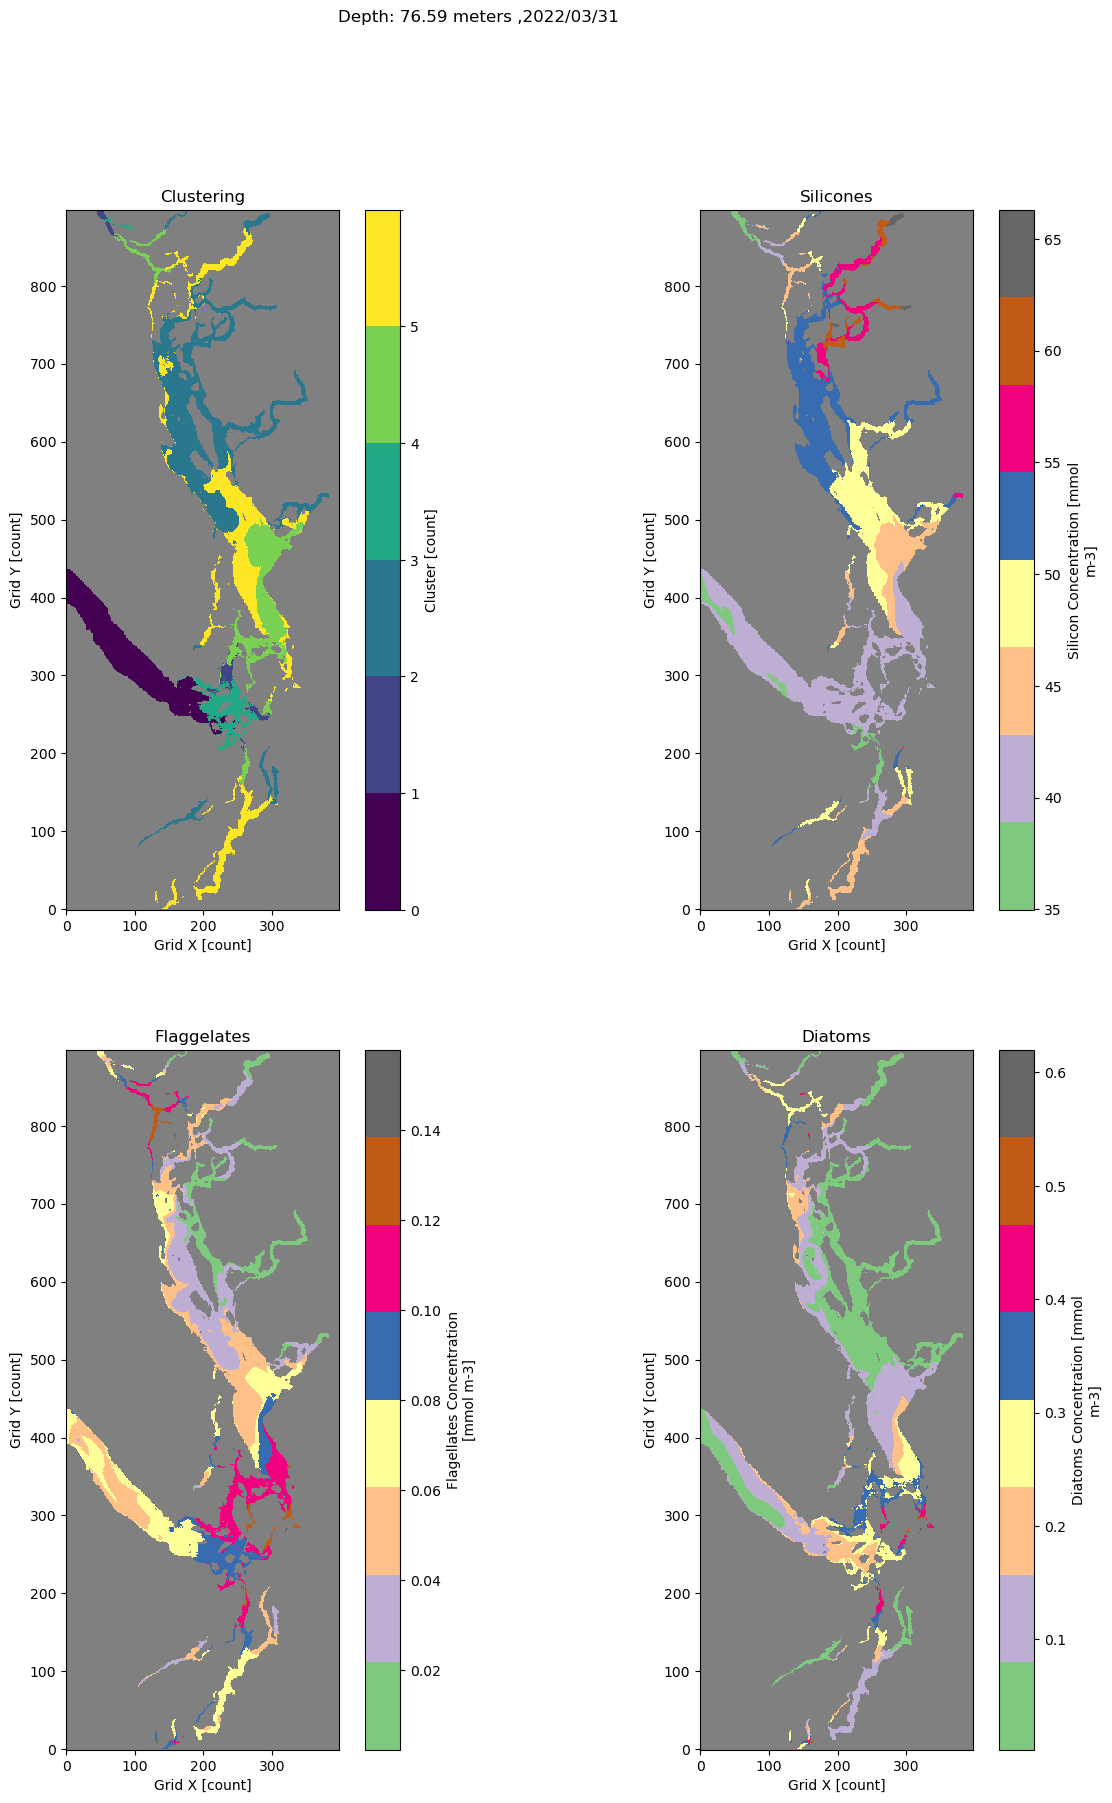

The amount of grid boxes for cluster 0 is 2448 

The minimum temperature for cluster 0 is 7.27 degrees Celsius
The maximum temperature for cluster 0 is 7.66 degrees Celsius
The mean temperature for cluster 0 is 7.48 degrees Celsius 

The minimum salinity for cluster 0 is 31.01 g/kg
The maximum salinity for cluster 0 is 32.16 g/kg
The mean salinity for cluster 0 is 31.81 g/kg 


The amount of grid boxes for cluster 1 is 8867 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 8.21 degrees Celsius
The mean temperature for cluster 1 is 7.84 degrees Celsius 

The minimum salinity for cluster 1 is 29.82 g/kg
The maximum salinity for cluster 1 is 30.81 g/kg
The mean salinity for cluster 1 is 30.16 g/kg 


The amount of grid boxes for cluster 2 is 9074 

The minimum temperature for cluster 2 is 7.61 degrees Celsius
The maximum temperature for cluster 2 is 8.64 degrees Celsius
The mean temperature for cluster 2 is 8.18 degrees Celsius 

The 

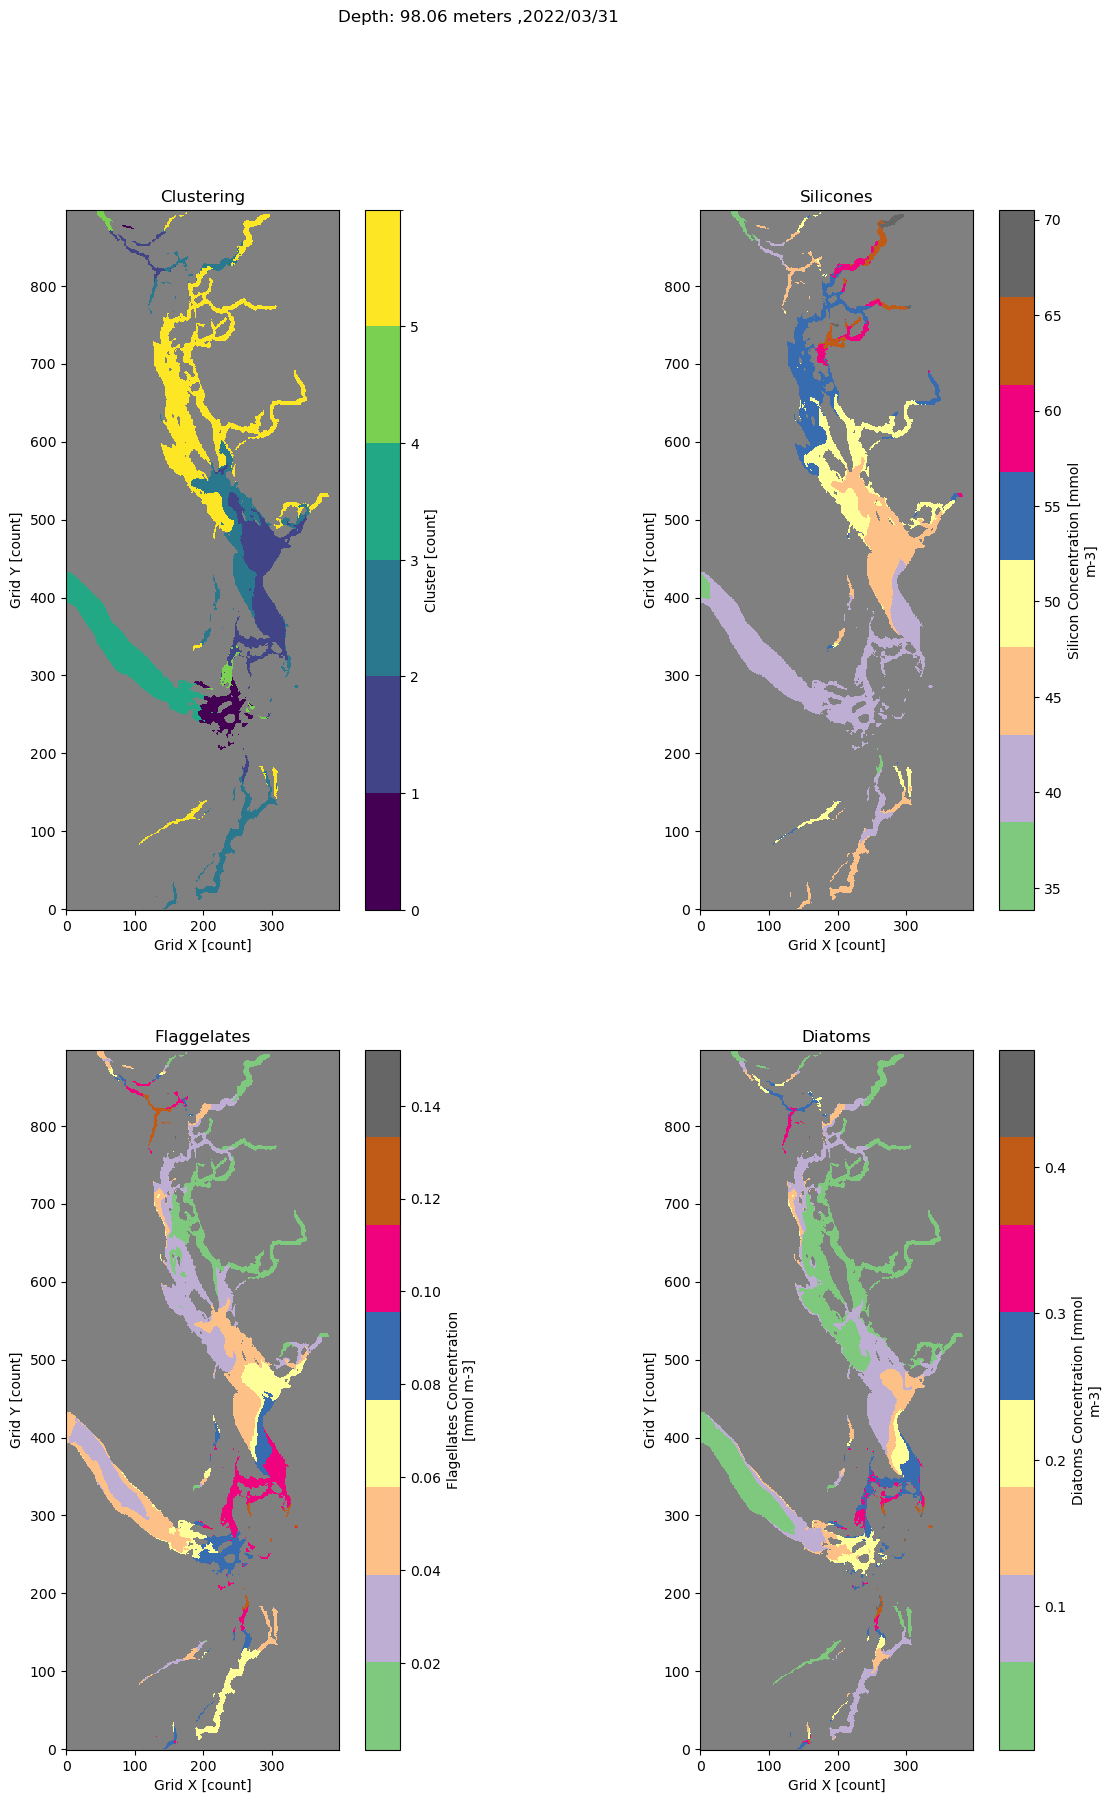

The amount of grid boxes for cluster 0 is 15228 

The minimum temperature for cluster 0 is 8.41 degrees Celsius
The maximum temperature for cluster 0 is 10.64 degrees Celsius
The mean temperature for cluster 0 is 8.97 degrees Celsius 

The minimum salinity for cluster 0 is 29.59 g/kg
The maximum salinity for cluster 0 is 30.59 g/kg
The mean salinity for cluster 0 is 30.37 g/kg 


The amount of grid boxes for cluster 1 is 222 

The minimum temperature for cluster 1 is 7.5 degrees Celsius
The maximum temperature for cluster 1 is 7.67 degrees Celsius
The mean temperature for cluster 1 is 7.57 degrees Celsius 

The minimum salinity for cluster 1 is 31.14 g/kg
The maximum salinity for cluster 1 is 31.69 g/kg
The mean salinity for cluster 1 is 31.45 g/kg 


The amount of grid boxes for cluster 2 is 7207 

The minimum temperature for cluster 2 is 6.94 degrees Celsius
The maximum temperature for cluster 2 is 7.3 degrees Celsius
The mean temperature for cluster 2 is 7.13 degrees Celsius 

The m

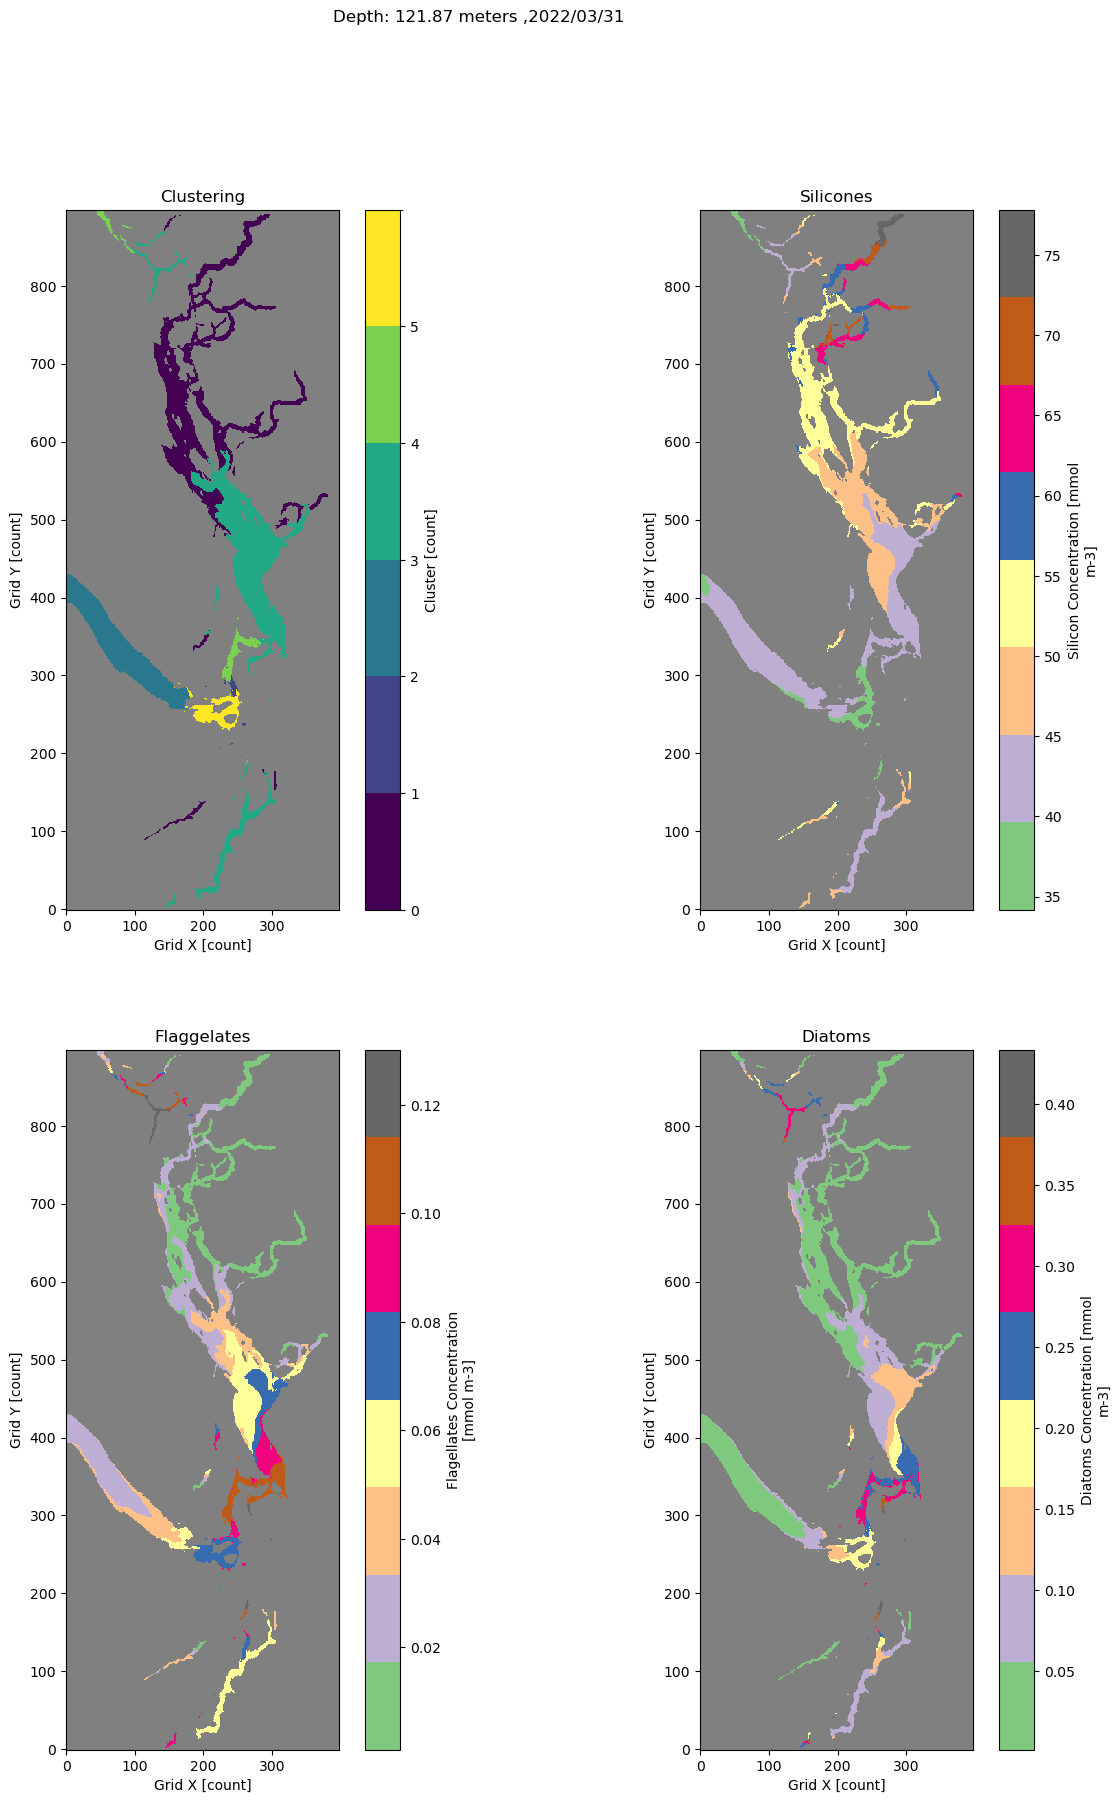

The amount of grid boxes for cluster 0 is 6773 

The minimum temperature for cluster 0 is 6.83 degrees Celsius
The maximum temperature for cluster 0 is 7.44 degrees Celsius
The mean temperature for cluster 0 is 7.1 degrees Celsius 

The minimum salinity for cluster 0 is 31.97 g/kg
The maximum salinity for cluster 0 is 33.79 g/kg
The mean salinity for cluster 0 is 33.39 g/kg 


The amount of grid boxes for cluster 2 is 942 

The minimum temperature for cluster 2 is 8.63 degrees Celsius
The maximum temperature for cluster 2 is 10.78 degrees Celsius
The mean temperature for cluster 2 is 9.08 degrees Celsius 

The minimum salinity for cluster 2 is 29.81 g/kg
The maximum salinity for cluster 2 is 30.87 g/kg
The mean salinity for cluster 2 is 30.54 g/kg 


The amount of grid boxes for cluster 3 is 10582 

The minimum temperature for cluster 3 is 7.3 degrees Celsius
The maximum temperature for cluster 3 is 7.68 degrees Celsius
The mean temperature for cluster 3 is 7.61 degrees Celsius 

The m

IndexError: index 5 is out of bounds for axis 0 with size 5

In [63]:
ds, temp, saline, date, mask, sil, flag, diat = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline, sil, flag, diat = masking(depth, temp, saline, mask, sil, flag, diat)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique, sil, flag, diat)


<xarray.DataArray 'silicon' (time_counter: 1, deptht: 40, y: 898, x: 398)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2022-03-31T12:00:00
  * deptht        (deptht) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
  * y             (y) int64 0 1 2 3 4 5 6 7 ... 890 891 892 893 894 895 896 897
  * x             (x) int64 0 1 2 3 4 5 6 7 ... 390 391 392 393 394 395 396 397
Attributes:
    standard_name:  mole_concentration_of_silicate_in_sea_water
    long_name:      Silicon Concentration
    units:          mmol m-3